## Preprocessing and clustering

In [2]:
import scanpy as sc
import anndata as ad
import celltypist as ct
import scrublet as scr
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# print("numpy:", numpy.__version__)
# print("pandas:", pandas.__version__)
# print("scanpy:", scanpy.__version__)
# print("anndata:", anndata.__version__)
# print("scipy:", scipy.__version__)
# print("h5py:", h5py.__version__)
# print("celltypist:", celltypist.__version__)

In [3]:
sc.settings.set_figure_params(dpi=110, facecolor="white")

In [4]:
# ------------------------ USER CONFIGURATION ------------------------

DATA_DIR = "/home/baldinelli/master-thesis/data/2ndRun"
RESOURCE_DIR = "/home/baldinelli/master-thesis/resources"
DATA = os.path.join(DATA_DIR, "fly_sci_imported.h5ad") 

In [5]:
adata = sc.read(DATA)
adata

AnnData object with n_obs × n_vars = 80293 × 17548
    obs: 'cell', 'n.umi', 'Size_Factor'
    var: 'V2', 'V3'
    uns: 'X_name', 'cds_version'

In [6]:
print(adata.obs.head())
print(adata.var.head())
print(adata.uns.keys())

                                                                                    cell  \
AATATTACTT_AGGTCAATTA_AAACCATAGT_AACGAGATCA  AATATTACTT_AGGTCAATTA_AAACCATAGT_AACGAGATCA   
CTAATTGCGA_AGGTCAATTA_AAACCATAGT_AACGAGATCA  CTAATTGCGA_AGGTCAATTA_AAACCATAGT_AACGAGATCA   
ATTGGCAGAT_CAAGATTAAG_AAACCATAGT_AACGAGATCA  ATTGGCAGAT_CAAGATTAAG_AAACCATAGT_AACGAGATCA   
CTAATTGCGA_CCAAGCTGAA_AAACCATAGT_AACGAGATCA  CTAATTGCGA_CCAAGCTGAA_AAACCATAGT_AACGAGATCA   
CTCGTCGTAG_CCAAGCTGAA_AAACCATAGT_AACGAGATCA  CTCGTCGTAG_CCAAGCTGAA_AAACCATAGT_AACGAGATCA   

                                             n.umi  Size_Factor  
AATATTACTT_AGGTCAATTA_AAACCATAGT_AACGAGATCA  363.0     1.233939  
CTAATTGCGA_AGGTCAATTA_AAACCATAGT_AACGAGATCA  103.0     0.350126  
ATTGGCAGAT_CAAGATTAAG_AAACCATAGT_AACGAGATCA  183.0     0.622068  
CTAATTGCGA_CCAAGCTGAA_AAACCATAGT_AACGAGATCA  160.0     0.543885  
CTCGTCGTAG_CCAAGCTGAA_AAACCATAGT_AACGAGATCA  185.0     0.628867  
                        V2               V3
Dmel_CR

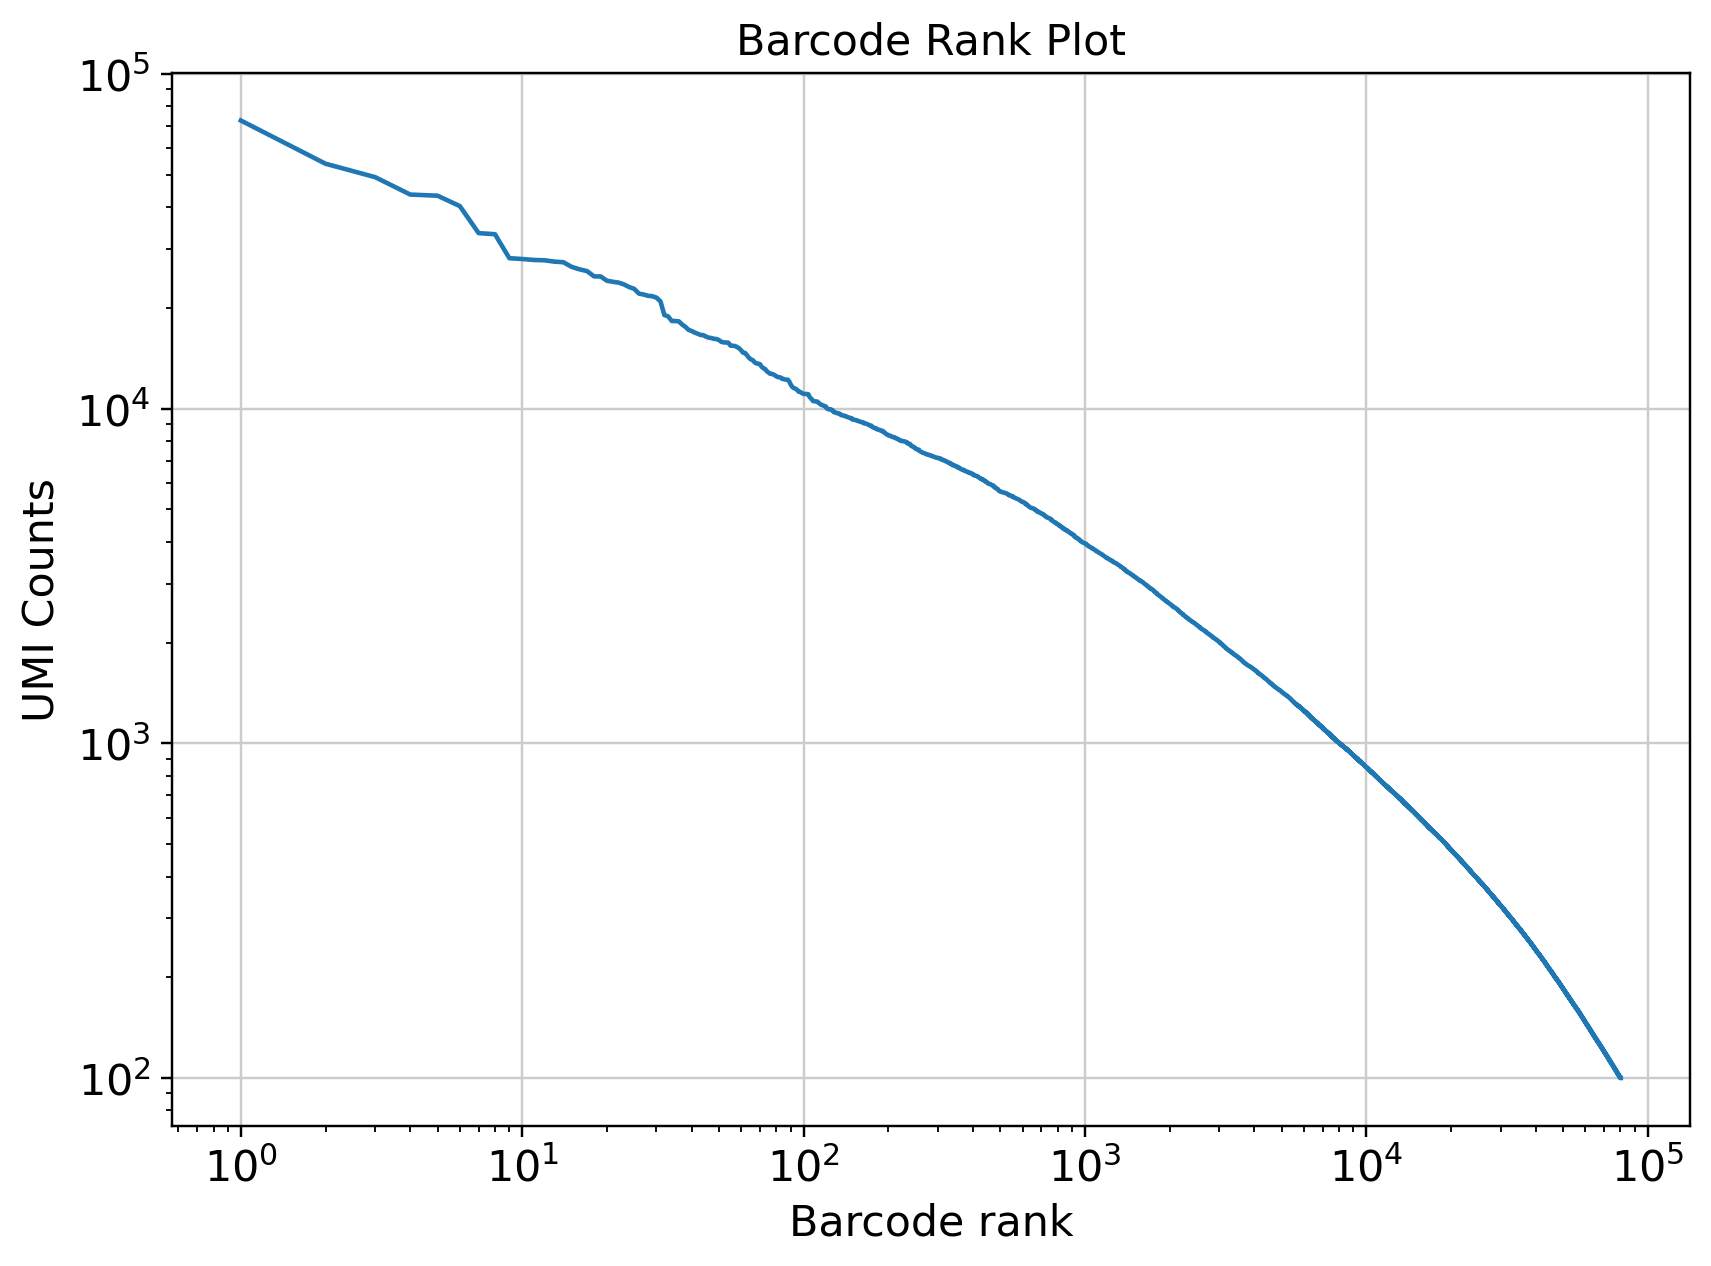

In [7]:
# sort the barcodes by total UMI count (descending)
sorted_counts = np.sort(adata.obs["n.umi"])[::-1]

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(sorted_counts) + 1), sorted_counts)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Barcode rank")
plt.ylabel("UMI Counts")
plt.title("Barcode Rank Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
print("Minimum UMI counts per cell:", adata.obs["n.umi"].min())

Minimum UMI counts per cell: 100.0


## Quality Control

The scanpy function calculate_qc_metrics() calculates common quality control (QC) metrics, which are largely based on calculateQCMetrics from scater [MCLW17]. One can pass specific gene population to calculate_qc_metrics() in order to calculate proportions of counts for these populations. Ribosomal genes are defined by distinct prefixes as listed below.

In [9]:
MART_EXPORT = os.path.join(RESOURCE_DIR, "mart_export.txt")
# Load the mart export file
mart = pd.read_csv(MART_EXPORT, sep="\t")
# Drop duplicates and nulls
mart = mart[["FlyBase annotation ID", "Gene name"]].dropna().drop_duplicates()

In [10]:
# Create mapping dictionary
id_to_name = dict(zip(mart["FlyBase annotation ID"], mart["Gene name"]))

In [11]:
# Strip Dmel_ and map
adata.var["clean_id"] = adata.var_names.str.replace("Dmel_", "", regex=False)
adata.var["gene_symbol"] = adata.var["clean_id"].map(id_to_name)

In [12]:
adata.var["gene_symbol"].notna().sum()

np.int64(17539)

In [13]:
# ribosomal genes
adata.var["ribo"] = adata.var["gene_symbol"].str.contains(r"Rp[SL]", na=False)
print(f"Number of ribosomal genes: {adata.var['ribo'].sum()}")

Number of ribosomal genes: 165


In [14]:
adata.var

V2               V3 clean_id      gene_symbol   ribo
Dmel_CR40469  Dmel_CR40469  Gene Expression  CR40469   lncRNA:CR40469  False
Dmel_CG17636  Dmel_CG17636  Gene Expression  CG17636          CG17636  False
Dmel_CG40494  Dmel_CG40494  Gene Expression  CG40494         RhoGAP1A  False
Dmel_CR43552  Dmel_CR43552  Gene Expression  CR43552         mir-4915  False
Dmel_CG17131  Dmel_CG17131  Gene Expression  CG17131              tyn  False
...                    ...              ...      ...              ...    ...
Dmel_CR34091  Dmel_CR34091  Gene Expression  CR34091  mt:tRNA:Ser-TGA  False
Dmel_CR34093  Dmel_CR34093  Gene Expression  CR34093  mt:tRNA:Leu-TAG  False
Dmel_CR34094  Dmel_CR34094  Gene Expression  CR34094         mt:lrRNA  False
Dmel_CR34095  Dmel_CR34095  Gene Expression  CR34095  mt:tRNA:Val-TAC  False
Dmel_CR34096  Dmel_CR34096  Gene Expression  CR34096         mt:srRNA  False

[17548 rows x 5 columns]

In [15]:
# Calculate QC metrics to ensure the required keys are present in adata.obs
sc.pp.calculate_qc_metrics(adata, qc_vars=["ribo"], inplace=True, log1p=True)

# Check the keys in adata.obs
print(adata.obs.keys())

Index(['cell', 'n.umi', 'Size_Factor', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'],
      dtype='object')


One can now inspect violin plots of some of the computed QC metrics:
- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in ribosomal genes

... storing 'gene_symbol' as categorical


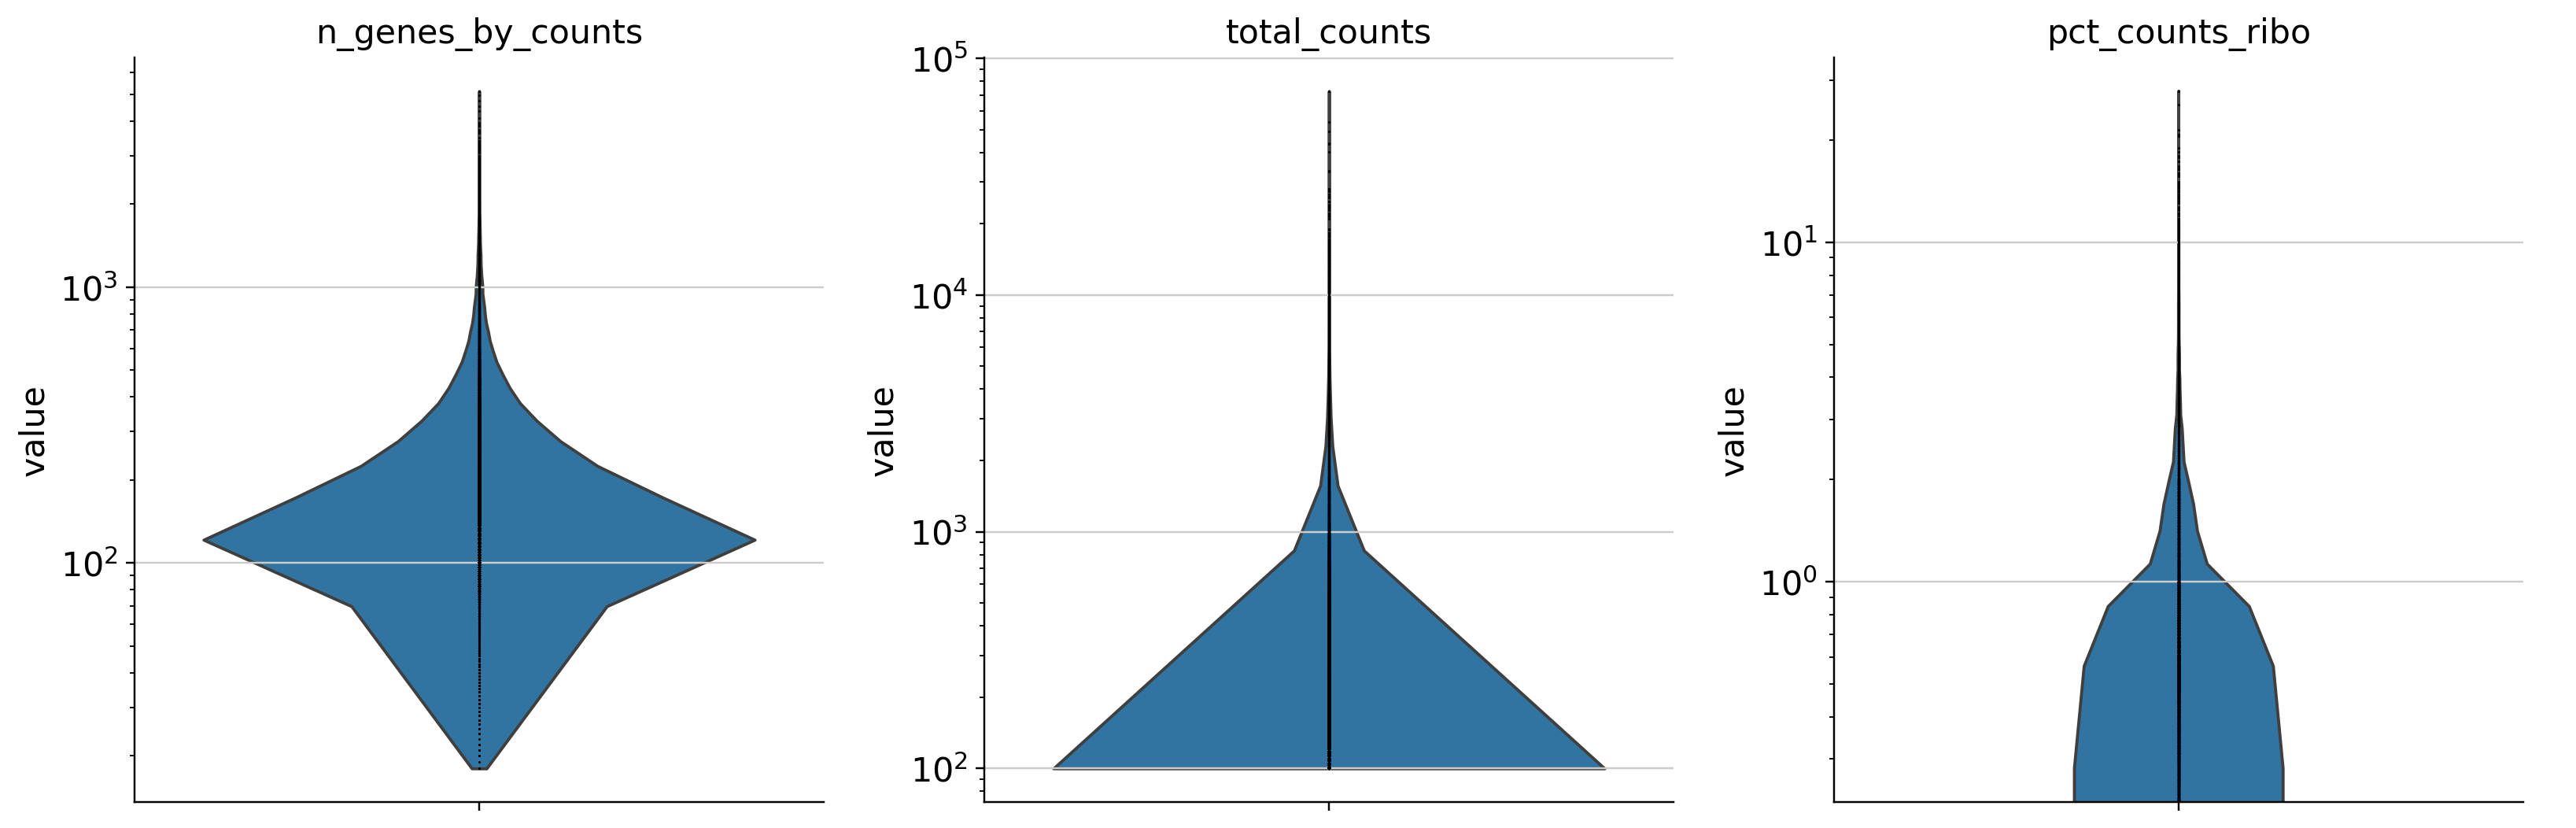

In [16]:
# Plot the violin plots for the calculated metrics
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_ribo"],
    jitter=0,
    multi_panel=True,
    log=True
)

Additionally, it is useful to consider QC metrics jointly by inspecting a scatter plot colored by pct_counts_rb.

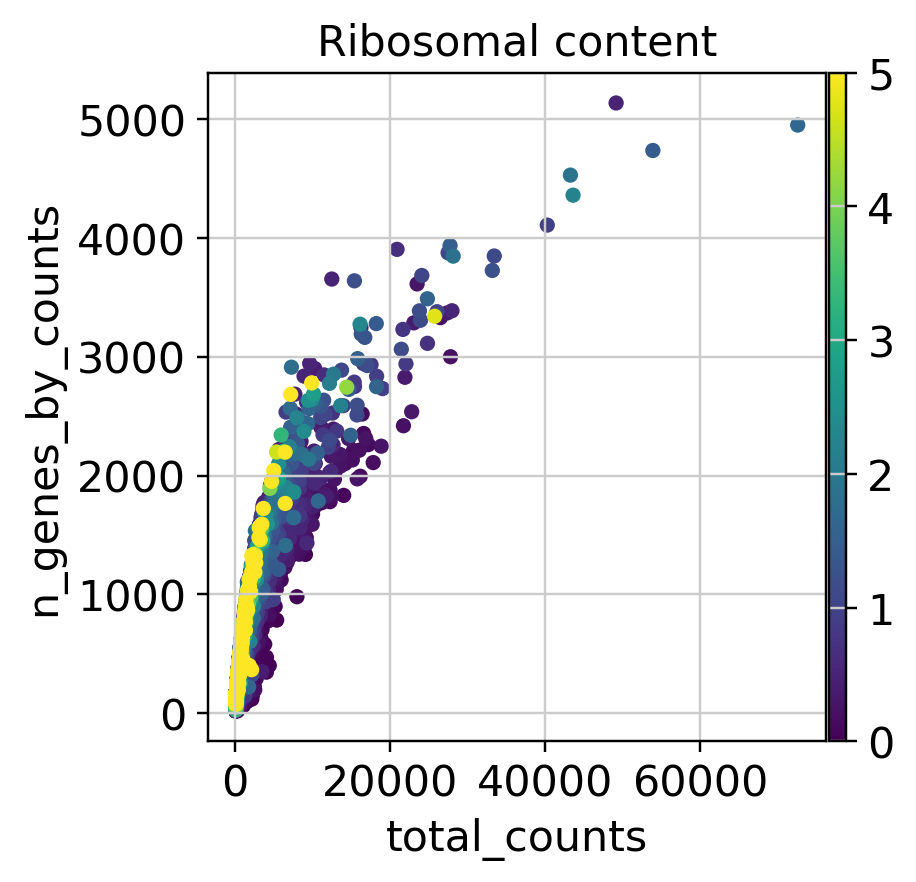

In [17]:
# Clip the values (e.g., between 0 and 10%)
adata.obs["pct_counts_ribo_clipped"] = np.clip(adata.obs["pct_counts_ribo"], 0, 5)

sc.pl.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_ribo_clipped",
    title="Ribosomal content",
    # incerease dot size to hundred of the scatter plot
    size=100
)
# increase dot size to hundred of the scatter plot
# Plot the scatterplot of ribosomal content with dot size 100

Since we cannot really see a plateaux, we can hypothesize that the nuclei may be undersequenced.

Sometimes what appears to be poor QC metrics can be driven by real biology so we start with a very permissive filtering strategy and revisit it at a later point. We therefore now only filter cells with less than 100 genes expressed and genes that are detected in less than 3 cells.

In [18]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

This is because later we'll perform l1 normalization, so the number of counts we see per cell is not indicative for its expression, the relative abundance is much more important. The issue is if we have a cell with very low counts, then we'd get half a milion gene expression (cpm normalization). Normalization only works only if we have enough counts.

## Doublet detection

As a next step, we run a doublet detection algorithm. Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps. Scanpy contains the doublet detection method Scrublet [Wolock et al., 2019]. Scrublet predicts cell doublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets. scanpy.pp.scrublet() adds doublet_score and predicted_doublet to .obs. One can now either filter directly on predicted_doublet or use the doublet_score later during clustering to filter clusters with high doublet scores.

In [19]:
# Paths to the required files
SCRUBLET_TSV = os.path.join(RESOURCE_DIR, "adata_scrublet.tsv")

if not os.path.exists(SCRUBLET_TSV):
    # Run scrublet if files are not found
    sc.pp.scrublet(adata)
    # Save the observation metadata (adata.obs) as a .tsv file
    adata.obs.to_csv(SCRUBLET_TSV, sep="\t")
else:
    # Load adata.obs from the saved .tsv file
    adata.obs = pd.read_csv(SCRUBLET_TSV, sep="\t", index_col=0)


- predicted_doublets.sum() counts how many cells were predicted as doublets. Since True = 1 and False = 0 in Python, summing gives the total number of Trues (i.e., doublets).
- len(predicted_doublets) gives the total number of cells.
- Dividing the number of predicted doublets by the total number of cells gives you the fraction of doublets.
- Multiplying by 100 converts it to a percentage.

In [20]:
#print the percentage of doublets
doublet_score = adata.obs['doublet_score']
predicted_doublets = adata.obs['predicted_doublet']

# Calculate doublet percentage
doublet_percentage = (predicted_doublets.sum() / len(predicted_doublets)) * 100
print(f"Predicted doublet percentage: {doublet_percentage:.2f}%")

Predicted doublet percentage: 10.23%


We can remove doublets by either filtering out the cells called as doublets, or waiting until we’ve done a clustering pass and filtering out any clusters with high doublet scores.

In [21]:
adata = adata[~adata.obs["predicted_doublet"].to_numpy()].copy() # remove doublets

## Filtering

In [22]:
# now we want to filter for a minimum UMI count of 300
sc.pp.filter_cells(adata, min_counts=300)
# print the number of cells after filtering
print(f"Number of cells after filtering: {adata.n_obs}")

Number of cells after filtering: 29514


## Normalization

The next preprocessing step is normalization. A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via target_sum in pp.normalize_total. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [23]:
# Saving count data
adata.layers["counts"] = adata.X.copy() # super important in order to save the raw counts for later use, like Deseq

In [24]:
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4) # paper from wolfgang for the 1e4 value
# Logarithmize the data
sc.pp.log1p(adata) # logarithm of the normalized counts after adding 1, to make it closer to a normal distribution

## Feature selection

As a next step, we want to reduce the dimensionality of the dataset and only include the most informative genes. This step is commonly known as feature selection. The scanpy function pp.highly_variable_genes annotates highly variable genes by reproducing the implementations of Seurat [Satija et al., 2015], Cell Ranger [Zheng et al., 2017], and Seurat v3 [Stuart et al., 2019] depending on the chosen flavor.

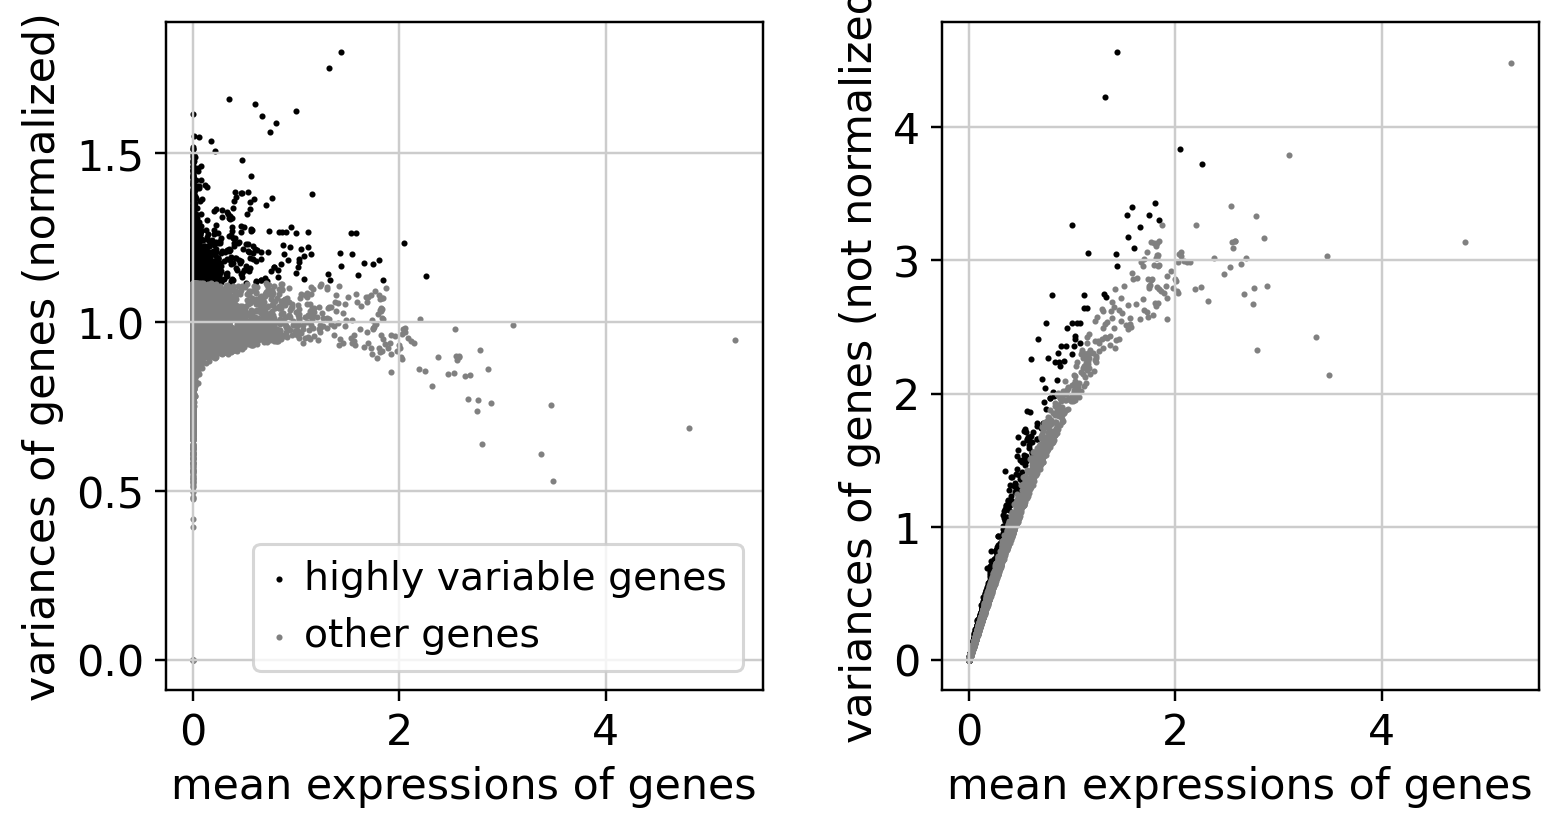

In [25]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3")
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [26]:
sc.tl.pca(adata)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function leiden() or tsne(). There does not seem to be signifigant downside to overestimating the numer of principal components.

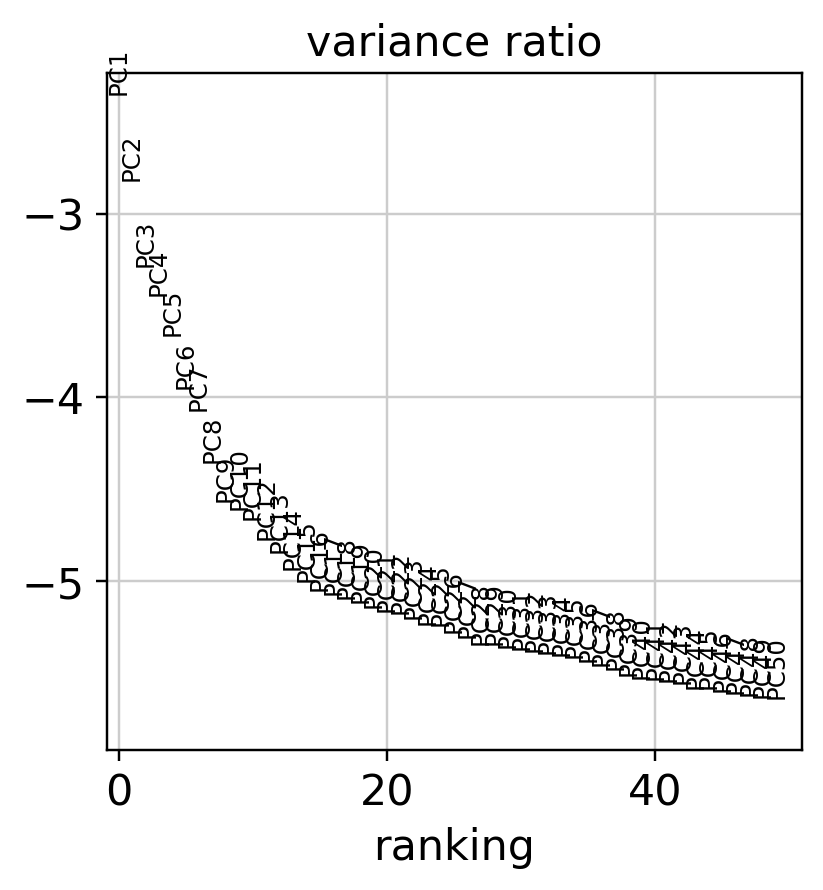

In [27]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

You can also plot the principal components to see if there are any potentially undesired features (e.g. batch, QC metrics) driving signifigant variation in this dataset. In this case, there isn’t anything too alarming, but it’s a good idea to explore this.

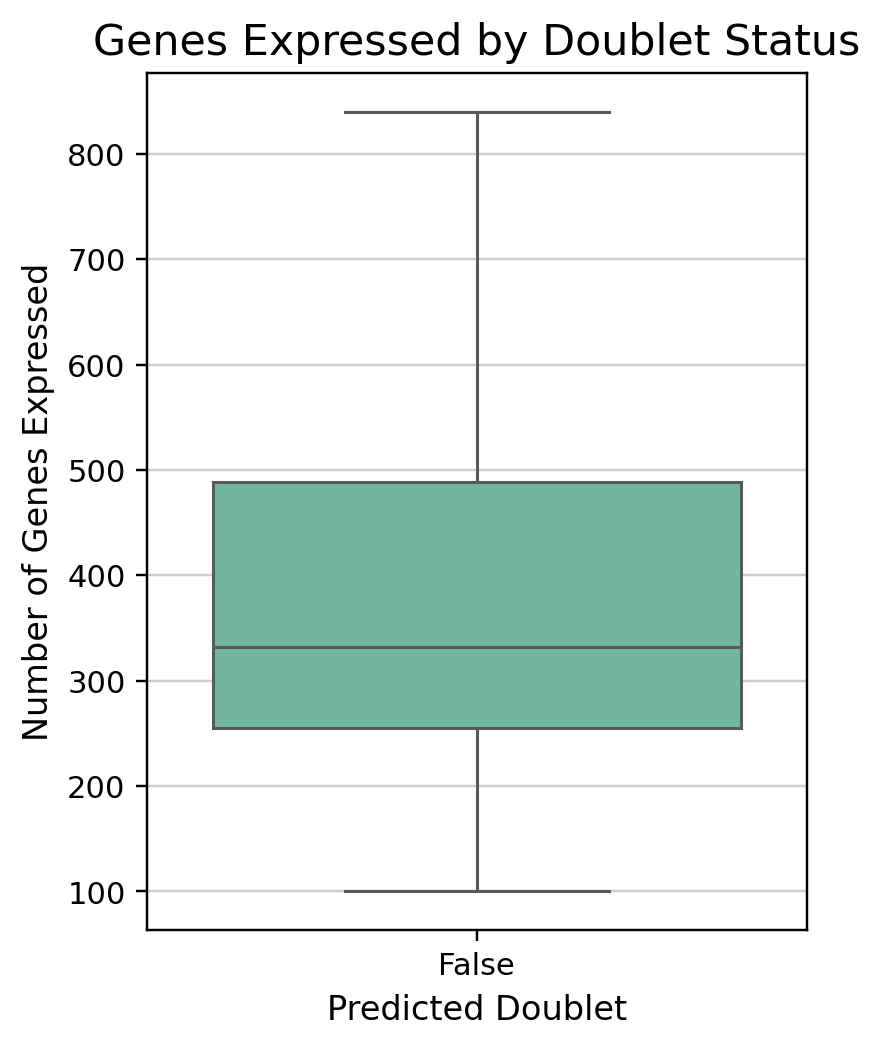

In [28]:
# Make sure both values are present
adata.obs["predicted_doublet"] = adata.obs["predicted_doublet"].astype(str)  # Convert to string if needed

plt.figure(figsize=(4, 5))
sns.boxplot(
    data=adata.obs,
    x="predicted_doublet",
    y="n_genes_by_counts",
    palette="Set2",
    showfliers=False
)
plt.xlabel("Predicted Doublet", fontsize=11)
plt.xticks(fontsize=10)
plt.ylabel("Number of Genes Expressed", fontsize=11)
plt.yticks(fontsize=10)
plt.title("Genes Expressed by Doublet Status", fontsize=14)
plt.tight_layout()
plt.show()

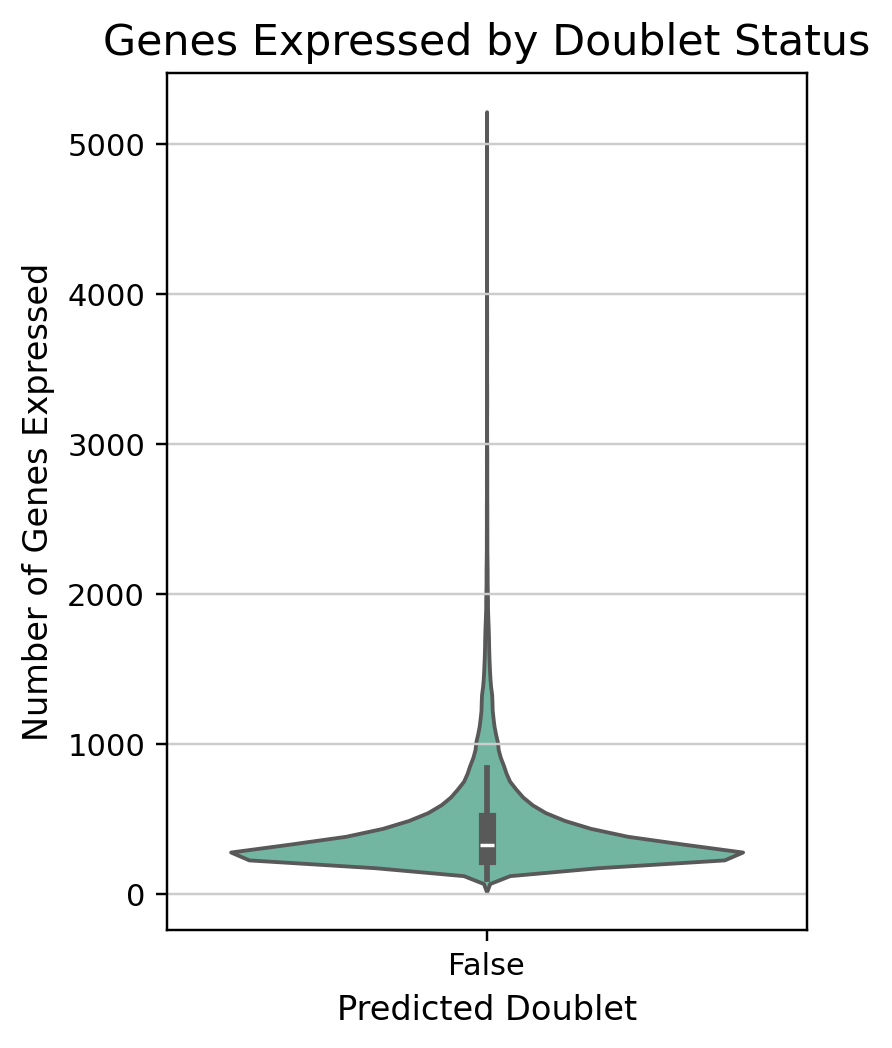

In [29]:
# now I make the same plot of gene expressed by doublet status, but as a violin plot
plt.figure(figsize=(4, 5))
sns.violinplot(
    data=adata.obs,
    x="predicted_doublet",
    y="n_genes_by_counts",
    palette="Set2"
)
plt.xlabel("Predicted Doublet", fontsize=11)
plt.xticks(fontsize=10)
plt.ylabel("Number of Genes Expressed", fontsize=11)
plt.yticks(fontsize=10)
plt.title("Genes Expressed by Doublet Status", fontsize=14)
plt.tight_layout()
plt.show()

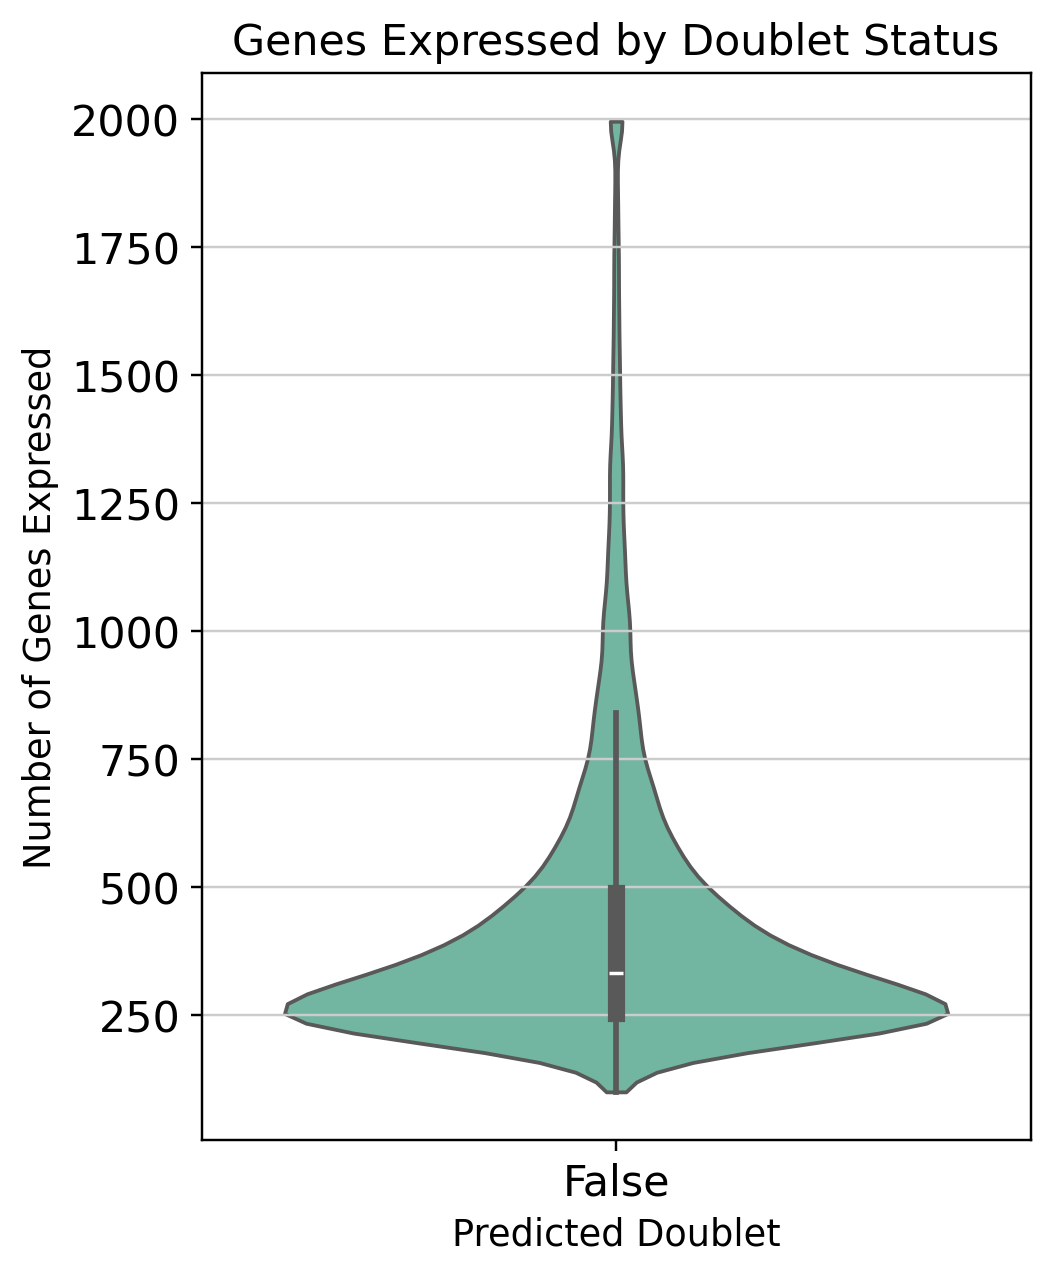

In [30]:
# Calculate a threshold (99.5th percentile) to clip outliers
threshold = np.percentile(adata.obs['n_genes_by_counts'], 99.5)

adata.obs['n_genes_clipped'] = adata.obs['n_genes_by_counts'].clip(upper=threshold)

plt.figure(figsize=(5, 6))
sns.violinplot(
    data=adata.obs,
    x='predicted_doublet',
    y='n_genes_clipped',
    palette='Set2',
    cut=0         # Limit violin tails to data range
)
plt.xlabel('Predicted Doublet', fontsize=12)
plt.ylabel('Number of Genes Expressed', fontsize=12)
plt.title('Genes Expressed by Doublet Status', fontsize=14)
plt.tight_layout()
plt.show()

## Nearest neighbor graph construction and visualization

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix.

In [31]:
#since I am in a filtering stage I want to save a data in an object s.t. I can retrieve the unfiltered dataset without the need to rerun the notebook from the very beginning
saved_adata1 = adata.copy()

In [32]:
# reset adata to the unfiltered dataset
# adata = saved_adata1.copy()

In [33]:
sc.pp.neighbors(adata) # default neighbors is 15, pcs default is none

This graph can then be embedded in two dimensions for visualization with UMAP (McInnes et al., 2018):

In [34]:
sc.tl.umap(adata)

We can now visualize the UMAP according to the predicted doublets.

... storing 'predicted_doublet' as categorical


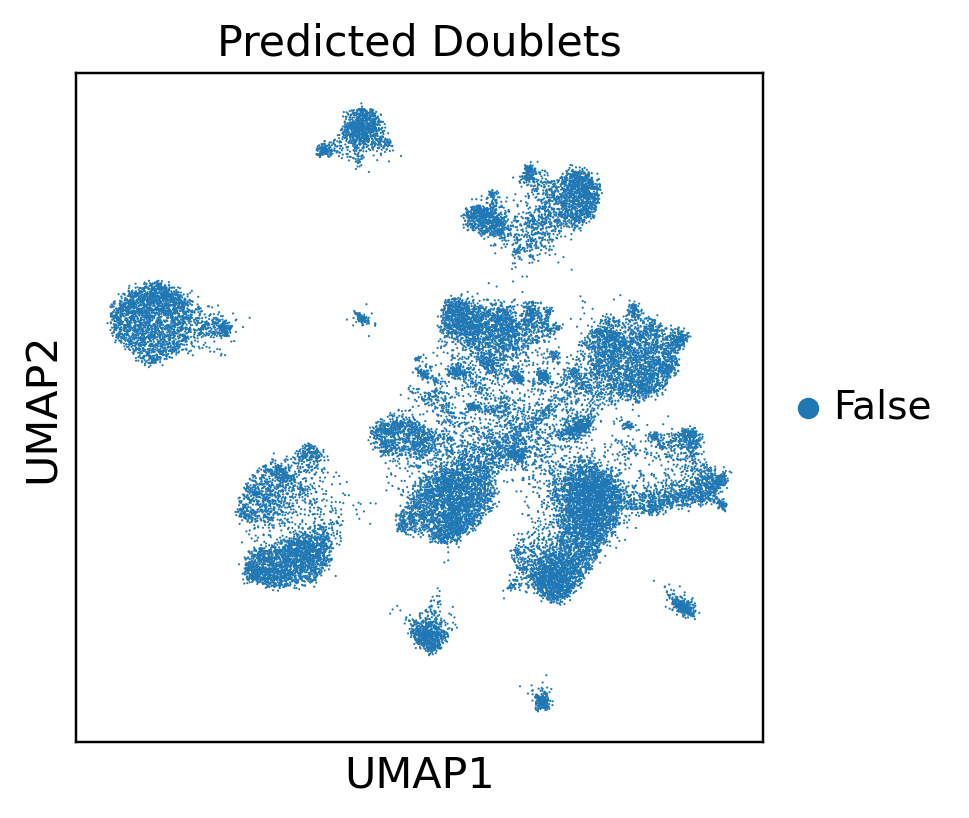

In [35]:
sc.pl.umap(
    adata,
    color="predicted_doublet",
    title="Predicted Doublets",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

If you inspect batch effects in your UMAP it can be beneficial to integrate across samples and perform batch correction/integration. We recommend checking out scanorama and scvi-tools for batch integration.

## Clustering

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) [Traag et al., 2019]. Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [36]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

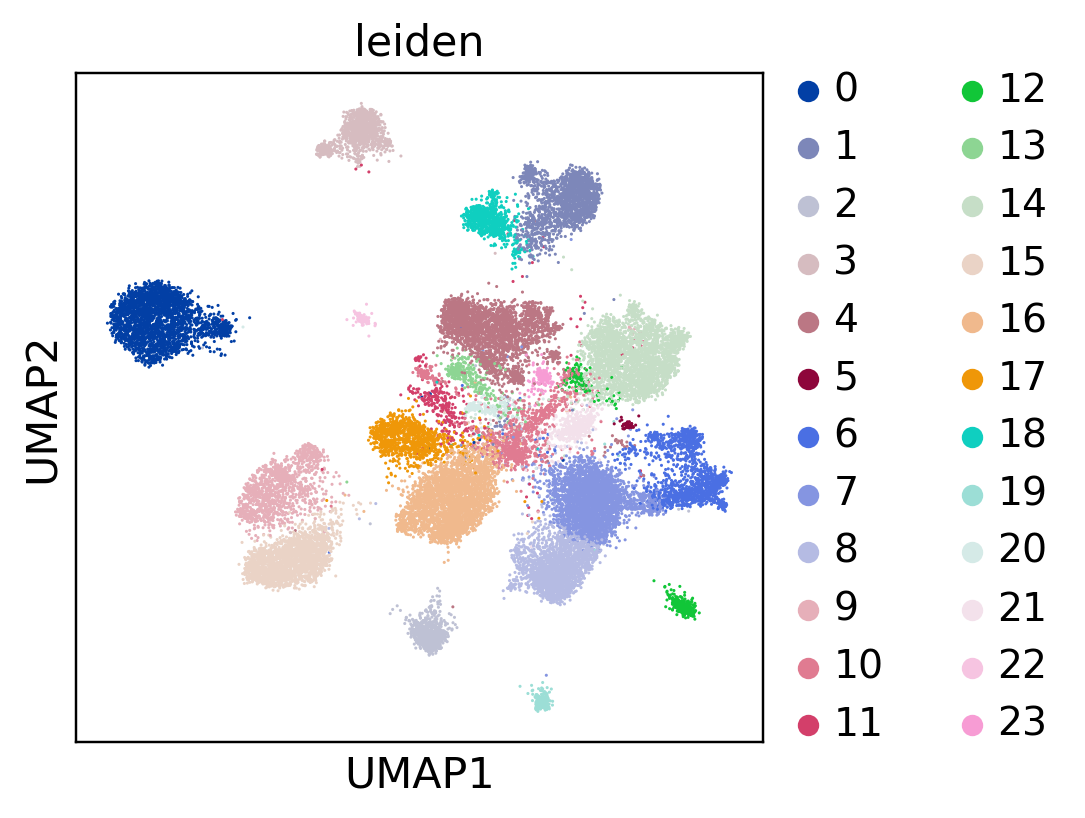

In [37]:
sc.pl.umap(adata, color=["leiden"])

## Re-assess quality control and cell filtering

As indicated before, we will now re-assess our filtering strategy by visualizing different QC metrics using UMAP.

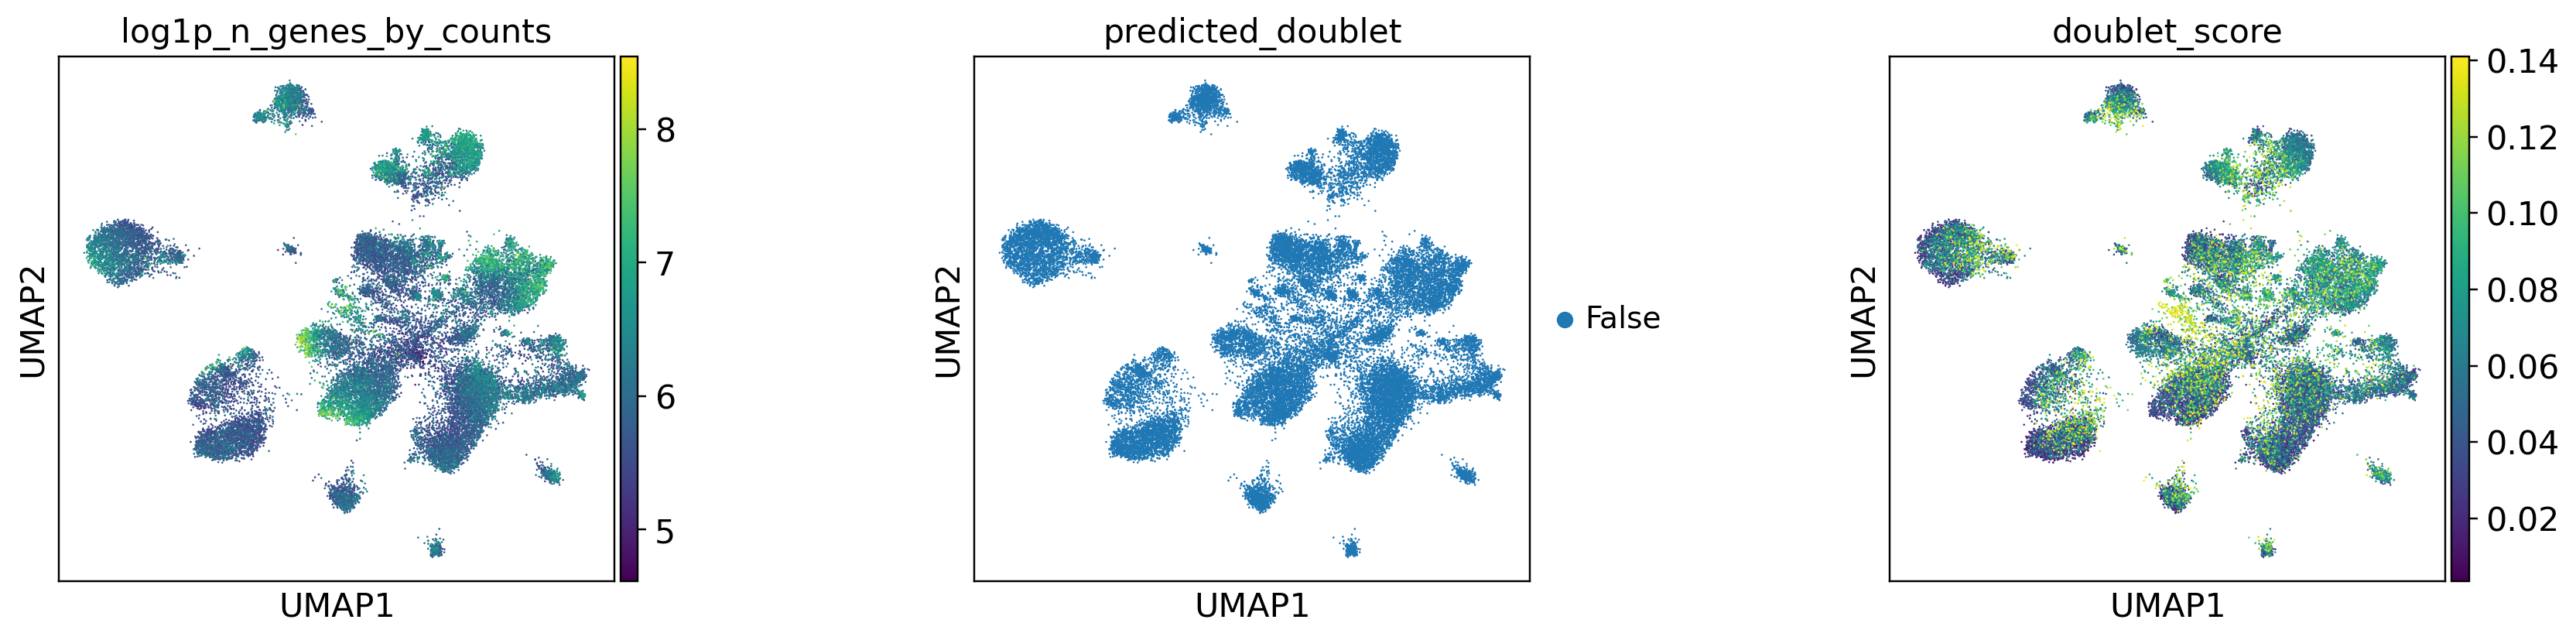

In [38]:
sc.pl.umap(
    adata,
    color=["log1p_n_genes_by_counts", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

In [39]:
adata

AnnData object with n_obs × n_vars = 29514 × 14315
    obs: 'cell', 'n.umi', 'Size_Factor', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_counts', 'n_genes_clipped', 'leiden'
    var: 'V2', 'V3', 'clean_id', 'gene_symbol', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'cds_version', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'predicted_doublet_colors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

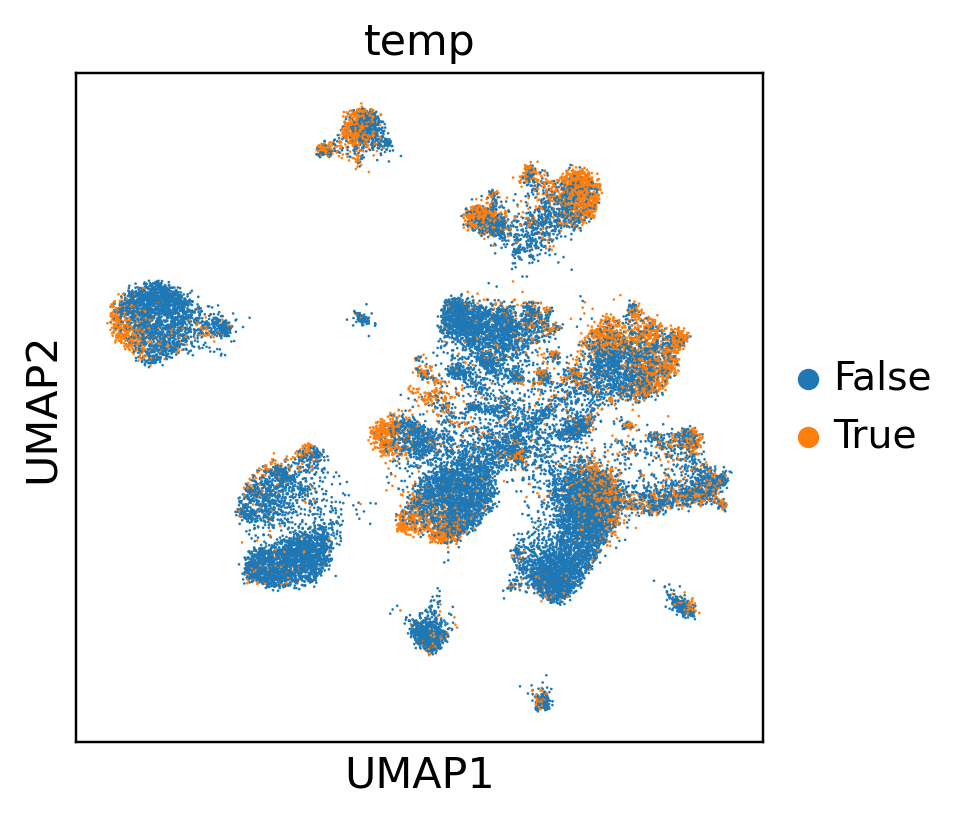

In [40]:
adata.obs["temp"] = adata.obs.total_counts > 1000
sc.pl.umap(
    adata,
    color = "temp",
    # increase horizontal space between panels
    wspace=0.5,
    size=3,

)

In [41]:
#print number of cells in adata
print(f"Number of cells in adata: {adata.n_obs}")

Number of cells in adata: 29514


In [42]:
#since I am in a filtering stage I want to save a data in an object s.t. I can retrieve the unfiltered dataset without the need to rerun the notebook from the very beginning
saved_adata2 = adata.copy()

In [43]:
# reset adata to the unfiltered dataset
# adata = saved_adata2.copy()

In [44]:
print(f"Number of cells in adata: {saved_adata2.n_obs}")

Number of cells in adata: 29514


In [45]:
# adata = adata[~adata.obs["predicted_doublet"].to_numpy()].copy() # remove doublets

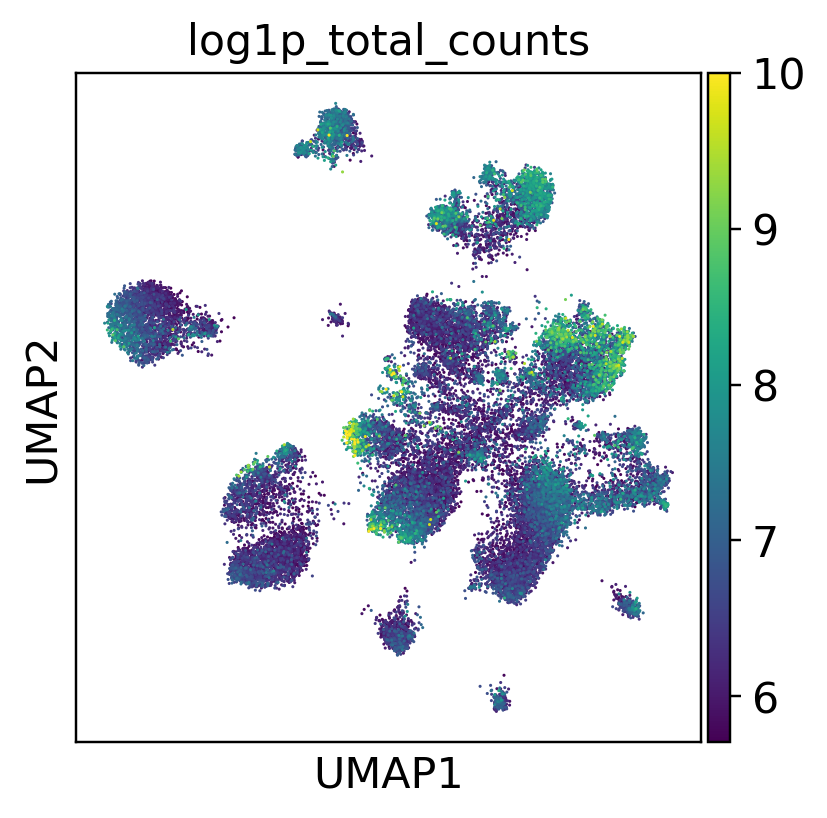

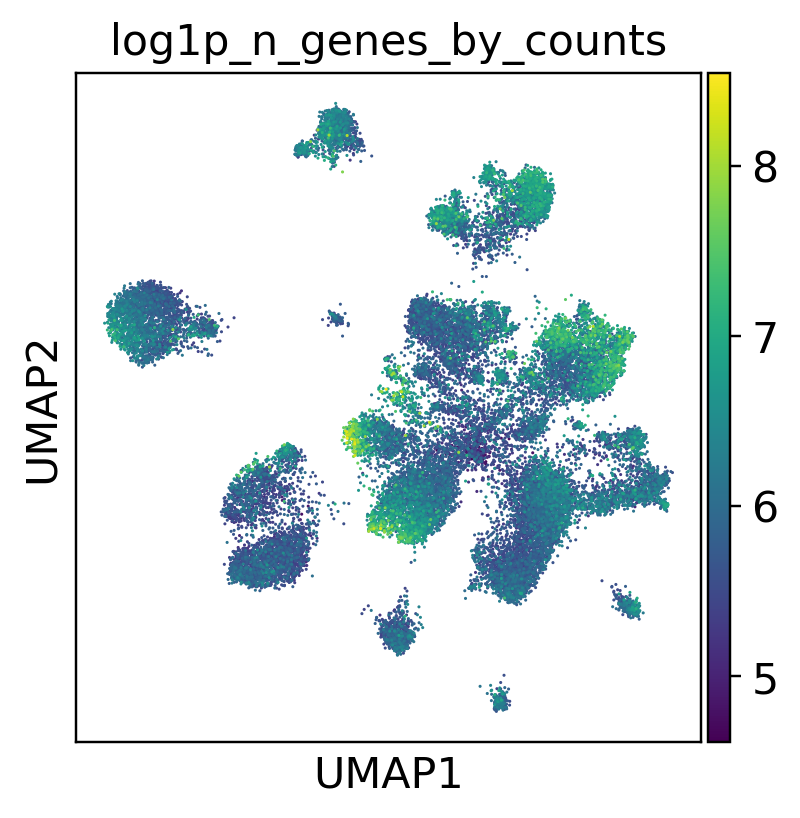

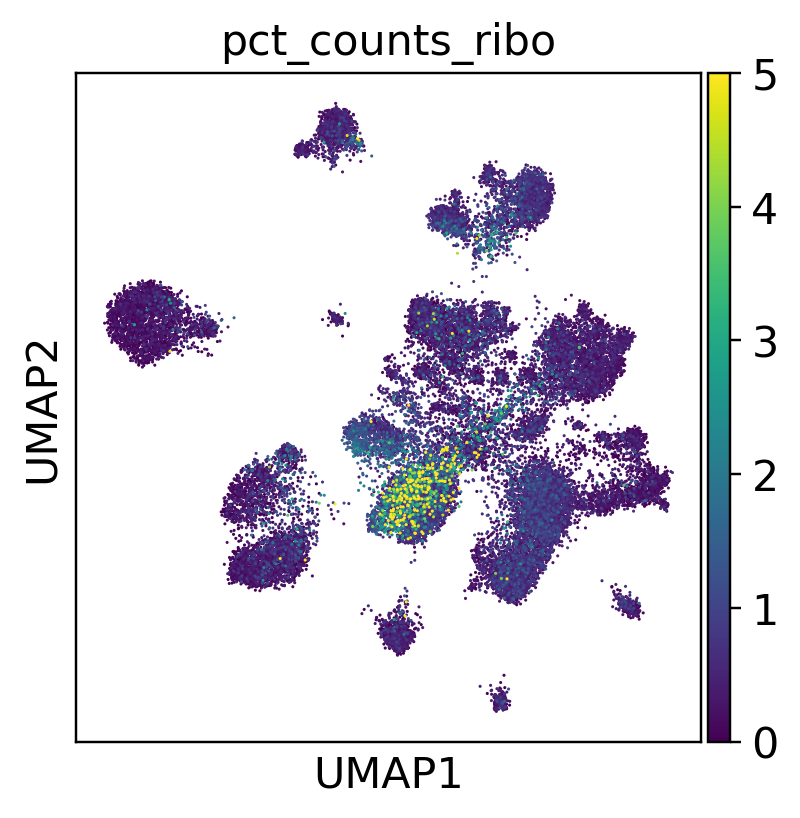

In [46]:
sc.pl.umap(
    adata, color=["log1p_total_counts"], 
    wspace=0.25,
    vmax=10
)
sc.pl.umap(
    adata, color=["log1p_n_genes_by_counts"], 
    wspace=0.25
)
#plot umap of pct_counts_ribo but with a smaller color scale
sc.pl.umap(
    adata, color= ["pct_counts_ribo"], 
    wspace=0.25, 
    vmin=0,
    vmax=5
)

In [47]:
#print number of cells in adata
print(f"Number of cells in adata: {adata.n_obs}")
#print number of UMIs per cell
print(f"Number of UMIs per cell: {adata.obs['n_genes_by_counts'].mean()}")

Number of cells in adata: 29514
Number of UMIs per cell: 434.37815951751713


## Cell-type annotation

We have now reached a point where we have obtained a set of cells with decent quality, and we can proceed to their annotation to known cell types. Typically, this is done using genes that are exclusively expressed by a given cell type, or in other words these genes are the marker genes of the cell types, and are thus used to distinguish the heterogeneous groups of cells in our data. Previous efforts have collected and curated various marker genes into available resources, such as CellMarker, TF-Marker, and PanglaoDB.

Commonly and classically, cell type annotation uses those marker genes subsequent to the grouping of the cells into clusters. So, let’s generate a set of clustering solutions which we can then use to annotate our cell types. Here, we will use the Leiden clustering algorithm which will extract cell communities from our nearest neighbours graph.

In [48]:
test = adata.var

print(adata.var["V2"])

Dmel_CG17636    Dmel_CG17636
Dmel_CG40494    Dmel_CG40494
Dmel_CG17131    Dmel_CG17131
Dmel_CR45473    Dmel_CR45473
Dmel_CG17707    Dmel_CG17707
                    ...     
Dmel_CR45846    Dmel_CR45846
Dmel_CR45847    Dmel_CR45847
Dmel_CR34075    Dmel_CR34075
Dmel_CR34094    Dmel_CR34094
Dmel_CR34096    Dmel_CR34096
Name: V2, Length: 14315, dtype: object


In [49]:
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_2", resolution=0.2)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_3", resolution=0.3)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_4", resolution=0.4)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res1", resolution=1)

Notably, the number of clusters that we define is largely arbitrary, and so is the resolution parameter that we use to control for it. As such, the number of clusters is ultimately bound to the stable and biologically-meaningful groups that we can ultimately distringuish, typically done by experts in the corresponding field or by using expert-curated prior knowledge in the form of markers.

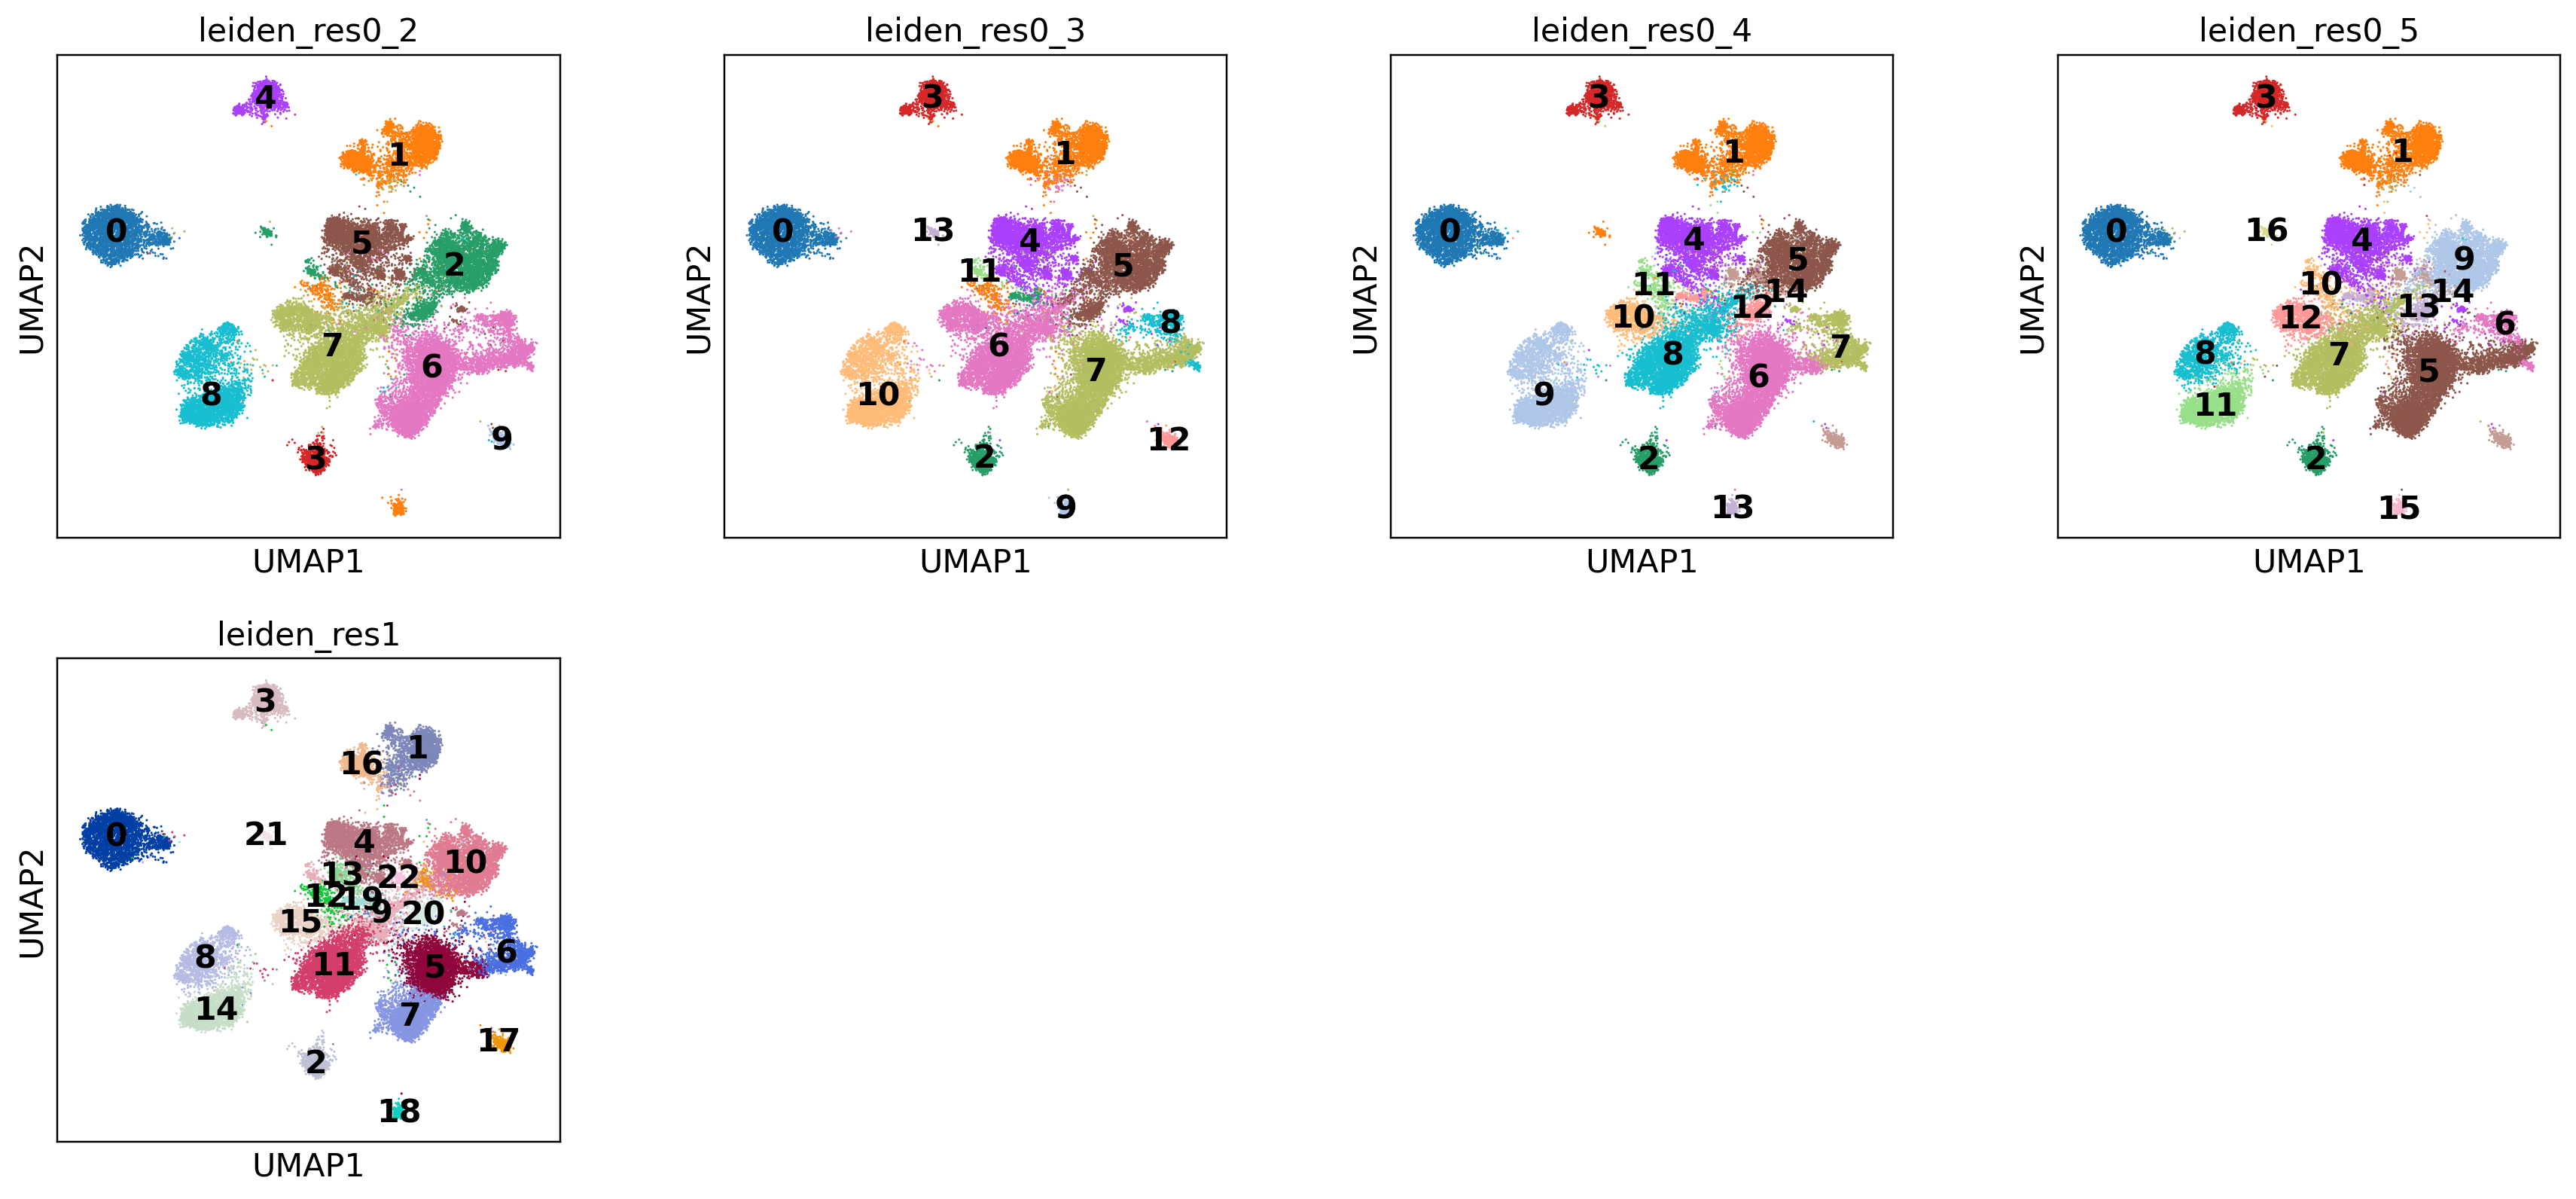

In [50]:
sc.pl.umap(
    adata,
    color=["leiden_res0_2", "leiden_res0_3", "leiden_res0_4", "leiden_res0_5", "leiden_res1"], 
    legend_loc="on data"
)

Though UMAPs should not be over-interpreted, here we can already see that in the highest resolution our data is over-clustered, while the lowest resolution is likely grouping cells which belong to distinct cell identities.

In [51]:
adata.var_names

Index(['Dmel_CG17636', 'Dmel_CG40494', 'Dmel_CG17131', 'Dmel_CR45473',
       'Dmel_CG17707', 'Dmel_CG3038', 'Dmel_CG2995', 'Dmel_CG42376',
       'Dmel_CG2945', 'Dmel_CG13377',
       ...
       'Dmel_CR45848', 'Dmel_CR45849', 'Dmel_CR40596', 'Dmel_CR45851',
       'Dmel_CR45845', 'Dmel_CR45846', 'Dmel_CR45847', 'Dmel_CR34075',
       'Dmel_CR34094', 'Dmel_CR34096'],
      dtype='object', length=14315)

In [52]:
adata_symbols = adata.copy()

In [53]:
adata_symbols.var_names = adata_symbols.var["gene_symbol"]

In [54]:
adata_symbols.var_names

CategoricalIndex(['CG17636', 'RhoGAP1A', 'tyn', 'lncRNA:CR45473', 'CG17707',
                  'CG3038', 'G9a', 'CG42376', 'cin', 'CG13377',
                  ...
                  '28SrRNA-Psi:CR45848', '5.8SrRNA-Psi:CR45849',
                  '28SrRNA-Psi:CR40596', '28SrRNA-Psi:CR45851',
                  'pre-rRNA:CR45845', 'pre-rRNA:CR45846', 'pre-rRNA:CR45847',
                  'mt:tRNA:Gly-TCC', 'mt:lrRNA', 'mt:srRNA'],
                 categories=['2mit', '4E-T', '5-HT1A', '5-HT1B', ..., 'zpg', 'zuc', 'zyd', 'zye'], ordered=False, dtype='category', name='gene_symbol', length=14315)

In [55]:
adata_symbols.var_names = adata_symbols.var_names.astype(str)

In [56]:
# now remove gene_symbol from the var column
adata_symbols.var.drop(columns=["gene_symbol"], inplace=True)

In [57]:
adata_symbols = adata_symbols[:, (adata_symbols.var_names.notna()) & (adata_symbols.var_names != 'nan')].copy()

In [58]:
dups = adata_symbols.var_names[adata_symbols.var_names.duplicated()]
print(f"Number of duplicated genes: {len(dups)}")
print(dups)

Number of duplicated genes: 0
Index([], dtype='object', name='gene_symbol')


In [59]:
adata_symbols.var

V2               V3 clean_id   ribo  \
gene_symbol                                                       
CG17636           Dmel_CG17636  Gene Expression  CG17636  False   
RhoGAP1A          Dmel_CG40494  Gene Expression  CG40494  False   
tyn               Dmel_CG17131  Gene Expression  CG17131  False   
lncRNA:CR45473    Dmel_CR45473  Gene Expression  CR45473  False   
CG17707           Dmel_CG17707  Gene Expression  CG17707  False   
...                        ...              ...      ...    ...   
pre-rRNA:CR45846  Dmel_CR45846  Gene Expression  CR45846  False   
pre-rRNA:CR45847  Dmel_CR45847  Gene Expression  CR45847  False   
mt:tRNA:Gly-TCC   Dmel_CR34075  Gene Expression  CR34075  False   
mt:lrRNA          Dmel_CR34094  Gene Expression  CR34094  False   
mt:srRNA          Dmel_CR34096  Gene Expression  CR34096  False   

                  n_cells_by_counts  mean_counts  log1p_mean_counts  \
gene_symbol                                                           
CG17636                          49     0.000673           0.000672   
RhoGAP1A                       5243     0.092100           0.088103   
tyn                            5557     0.113136           0.107181   
lncRNA:CR45473                  230     0.002927           0.002923   
CG17707                         193     0.002454           0.002451   
...                             ...          ...                ...   
pre-rRNA:CR45846               2771     0.041921           0.041067   
pre-rRNA:CR45847                191     0.002404           0.002401   
mt:tRNA:Gly-TCC                   3     0.000050           0.000050   
mt:lrRNA                       7768     0.243371           0.217826   
mt:srRNA                       1282     0.023564           0.023290   

                  pct_dropout_by_counts  total_counts  log1p_total_counts  \
gene_symbol                                                                 
CG17636                       99.938974          54.0            4.007333   
RhoGAP1A                      93.470166        7395.0            8.908695   
tyn                           93.079098        9084.0            9.114380   
lncRNA:CR45473                99.713549         235.0            5.463832   
CG17707                       99.759630         197.0            5.288267   
...                                 ...           ...                 ...   
pre-rRNA:CR45846              96.548890        3366.0            8.121777   
pre-rRNA:CR45847              99.762121         193.0            5.267858   
mt:tRNA:Gly-TCC               99.996264           4.0            1.609438   
mt:lrRNA                      90.325433       19541.0            9.880321   
mt:srRNA                      98.403348        1892.0            7.545918   

                  n_cells  highly_variable  highly_variable_rank     means  \
gene_symbol                                                                  
CG17636                49            False                   NaN  0.002370   
RhoGAP1A             5088            False                   NaN  0.300498   
tyn                  5347            False                   NaN  0.326938   
lncRNA:CR45473        220            False                   NaN  0.012521   
CG17707               187            False                   NaN  0.009970   
...                   ...              ...                   ...       ...   
pre-rRNA:CR45846     2576            False                   NaN  0.150720   
pre-rRNA:CR45847      181            False                   NaN  0.010637   
mt:tRNA:Gly-TCC         3            False                   NaN  0.000129   
mt:lrRNA             7135            False                   NaN  0.350885   
mt:srRNA             1161            False                   NaN  0.056534   

                  variances  variances_norm  
gene_symbol                                  
CG17636            0.004907        0.838325  
RhoGAP1A           0.690473        0.922167  
tyn                0.820587    

In [60]:
adata_symbols.write(os.path.join(DATA_DIR, "fly_sci_leiden.h5ad"))

## Manual cell-type annotation

Cell type annotation is laborous and repetitive task, one which typically requires multiple rounds of subclustering and re-annotation. It’s difficult to show the entirety of the process in this tutorial, but we aim to show how the tools scanpy provides assist in this process.

We have now reached a point where we have obtained a set of cells with decent quality, and we can proceed to their annotation to known cell types. Typically, this is done using genes that are exclusively expressed by a given cell type, or in other words these genes are the marker genes of the cell types, and are thus used to distinguish the heterogeneous groups of cells in our data. Previous efforts have collected and curated various marker genes into available resources, such as CellMarker, TF-Marker, and PanglaoDB. The cellxgene gene expression tool can also be quite useful to see which cell types a gene has been expressed in across many existing datasets.

Commonly and classically, cell type annotation uses those marker genes subsequent to the grouping of the cells into clusters. So, let’s generate a set of clustering solutions which we can then use to annotate our cell types. Here, we will use the Leiden clustering algorithm which will extract cell communities from our nearest neighbours graph.

In [61]:
for res in [0.2, 0.3, 0.4, 0.5, 1.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

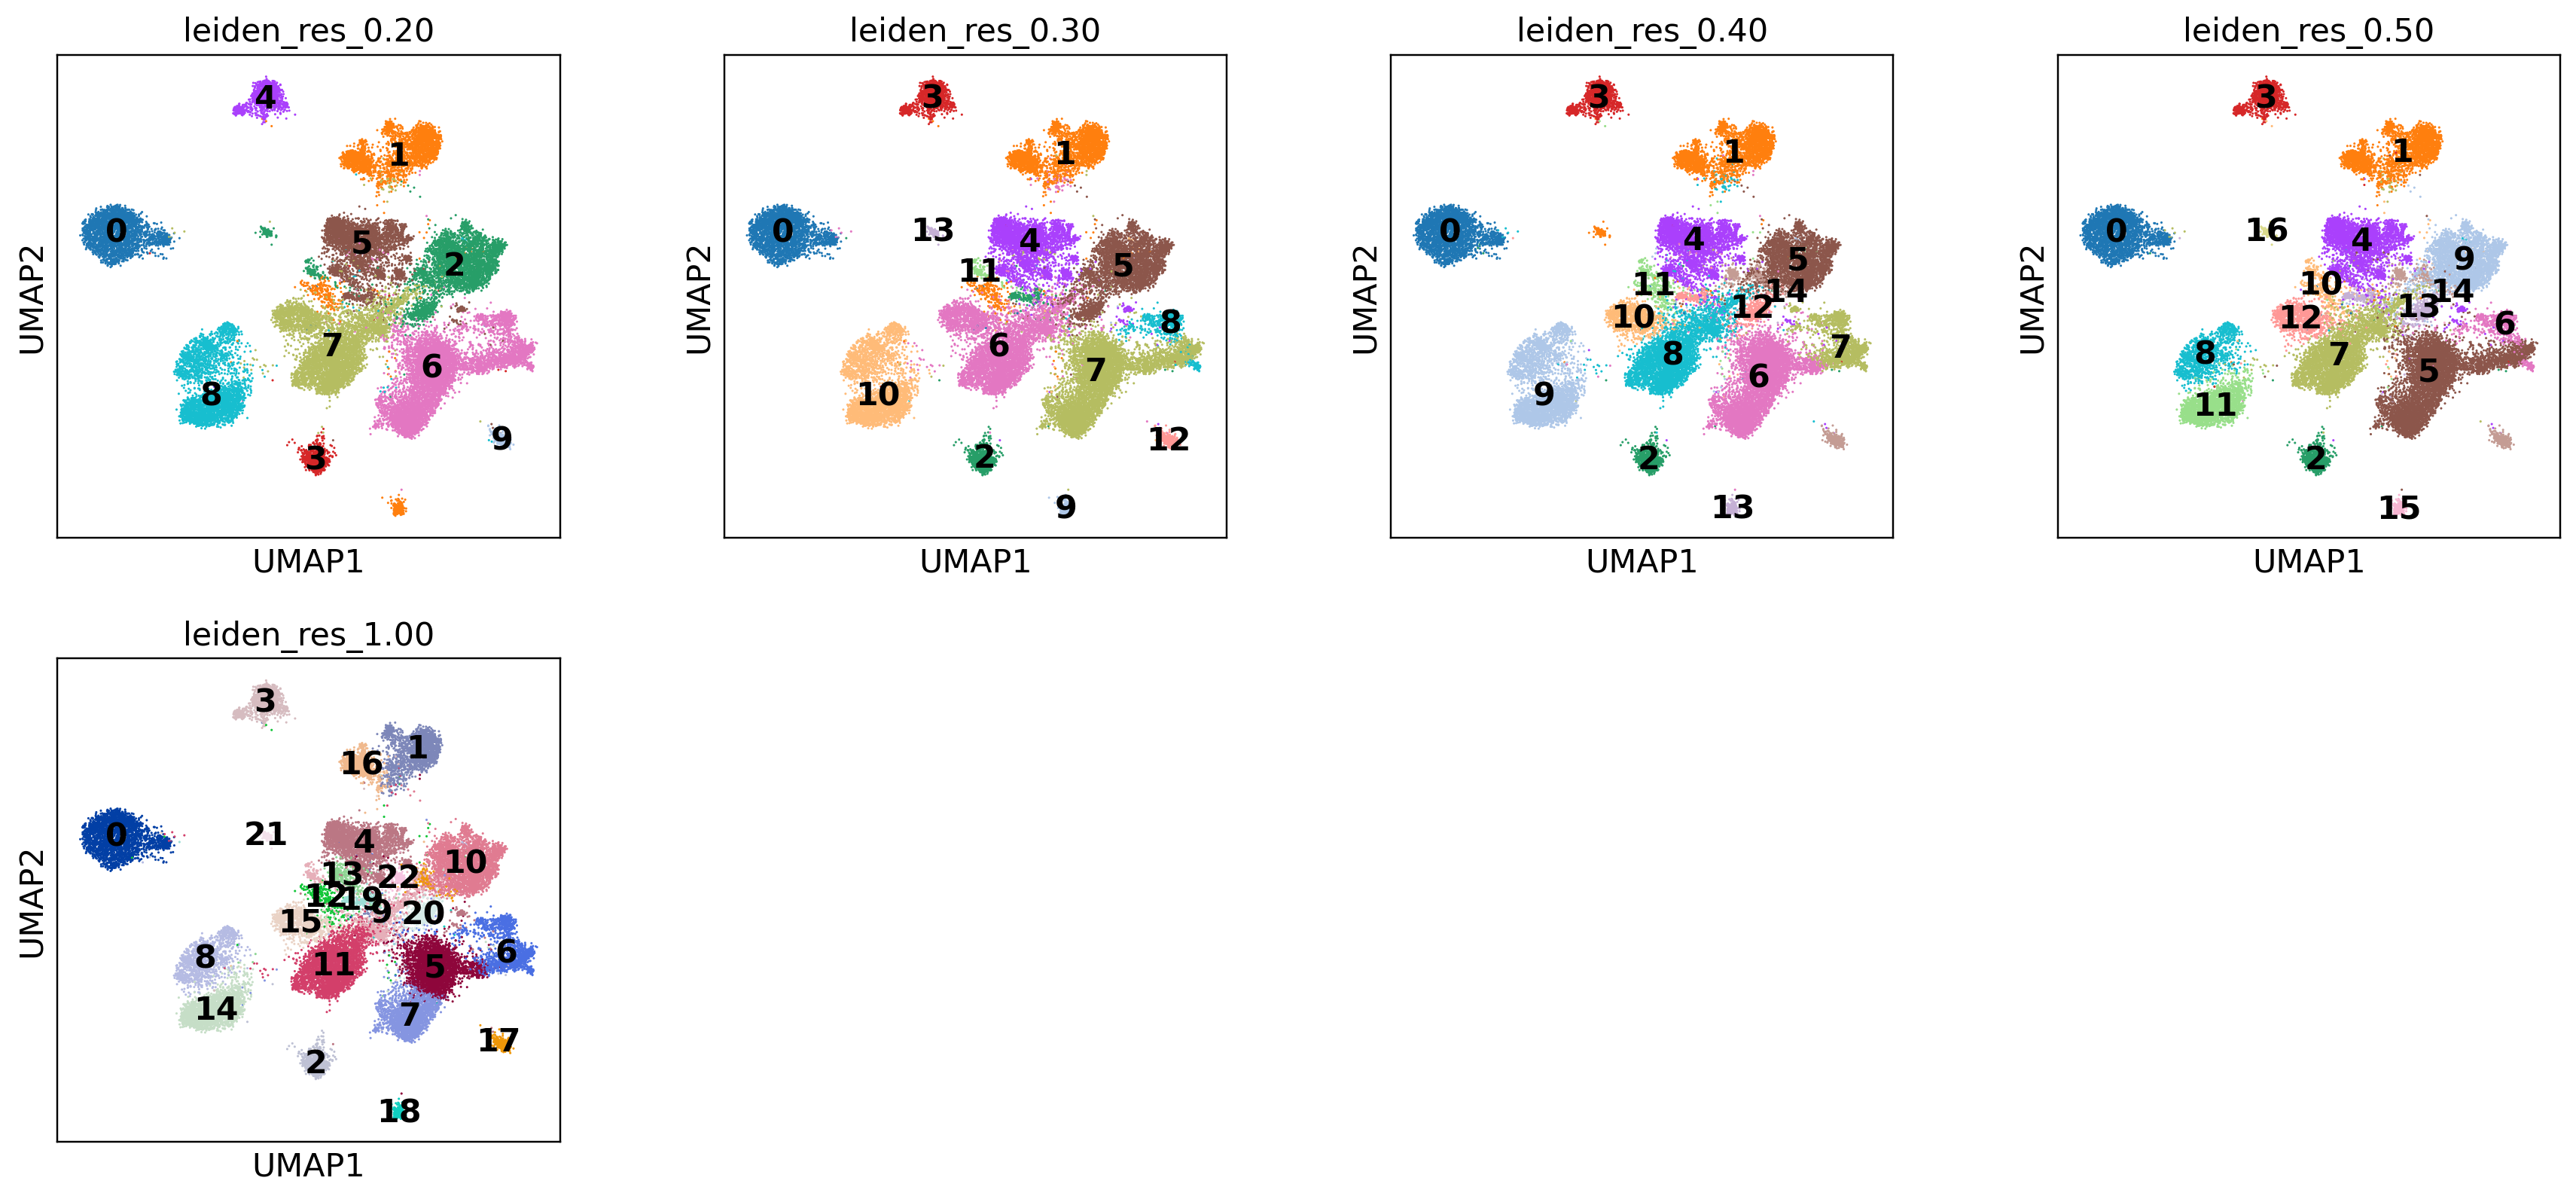

In [62]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.20", "leiden_res_0.30", "leiden_res_0.40", "leiden_res_0.50", "leiden_res_1.00"],
    legend_loc="on data",
)

In [63]:
group_sizes = adata.obs["leiden_res_0.20"].value_counts()
valid_groups = group_sizes[group_sizes > 1].index.tolist()

In [64]:
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden_res_0.20",
    groups=valid_groups,
    method="t-test",
    n_genes=25
)

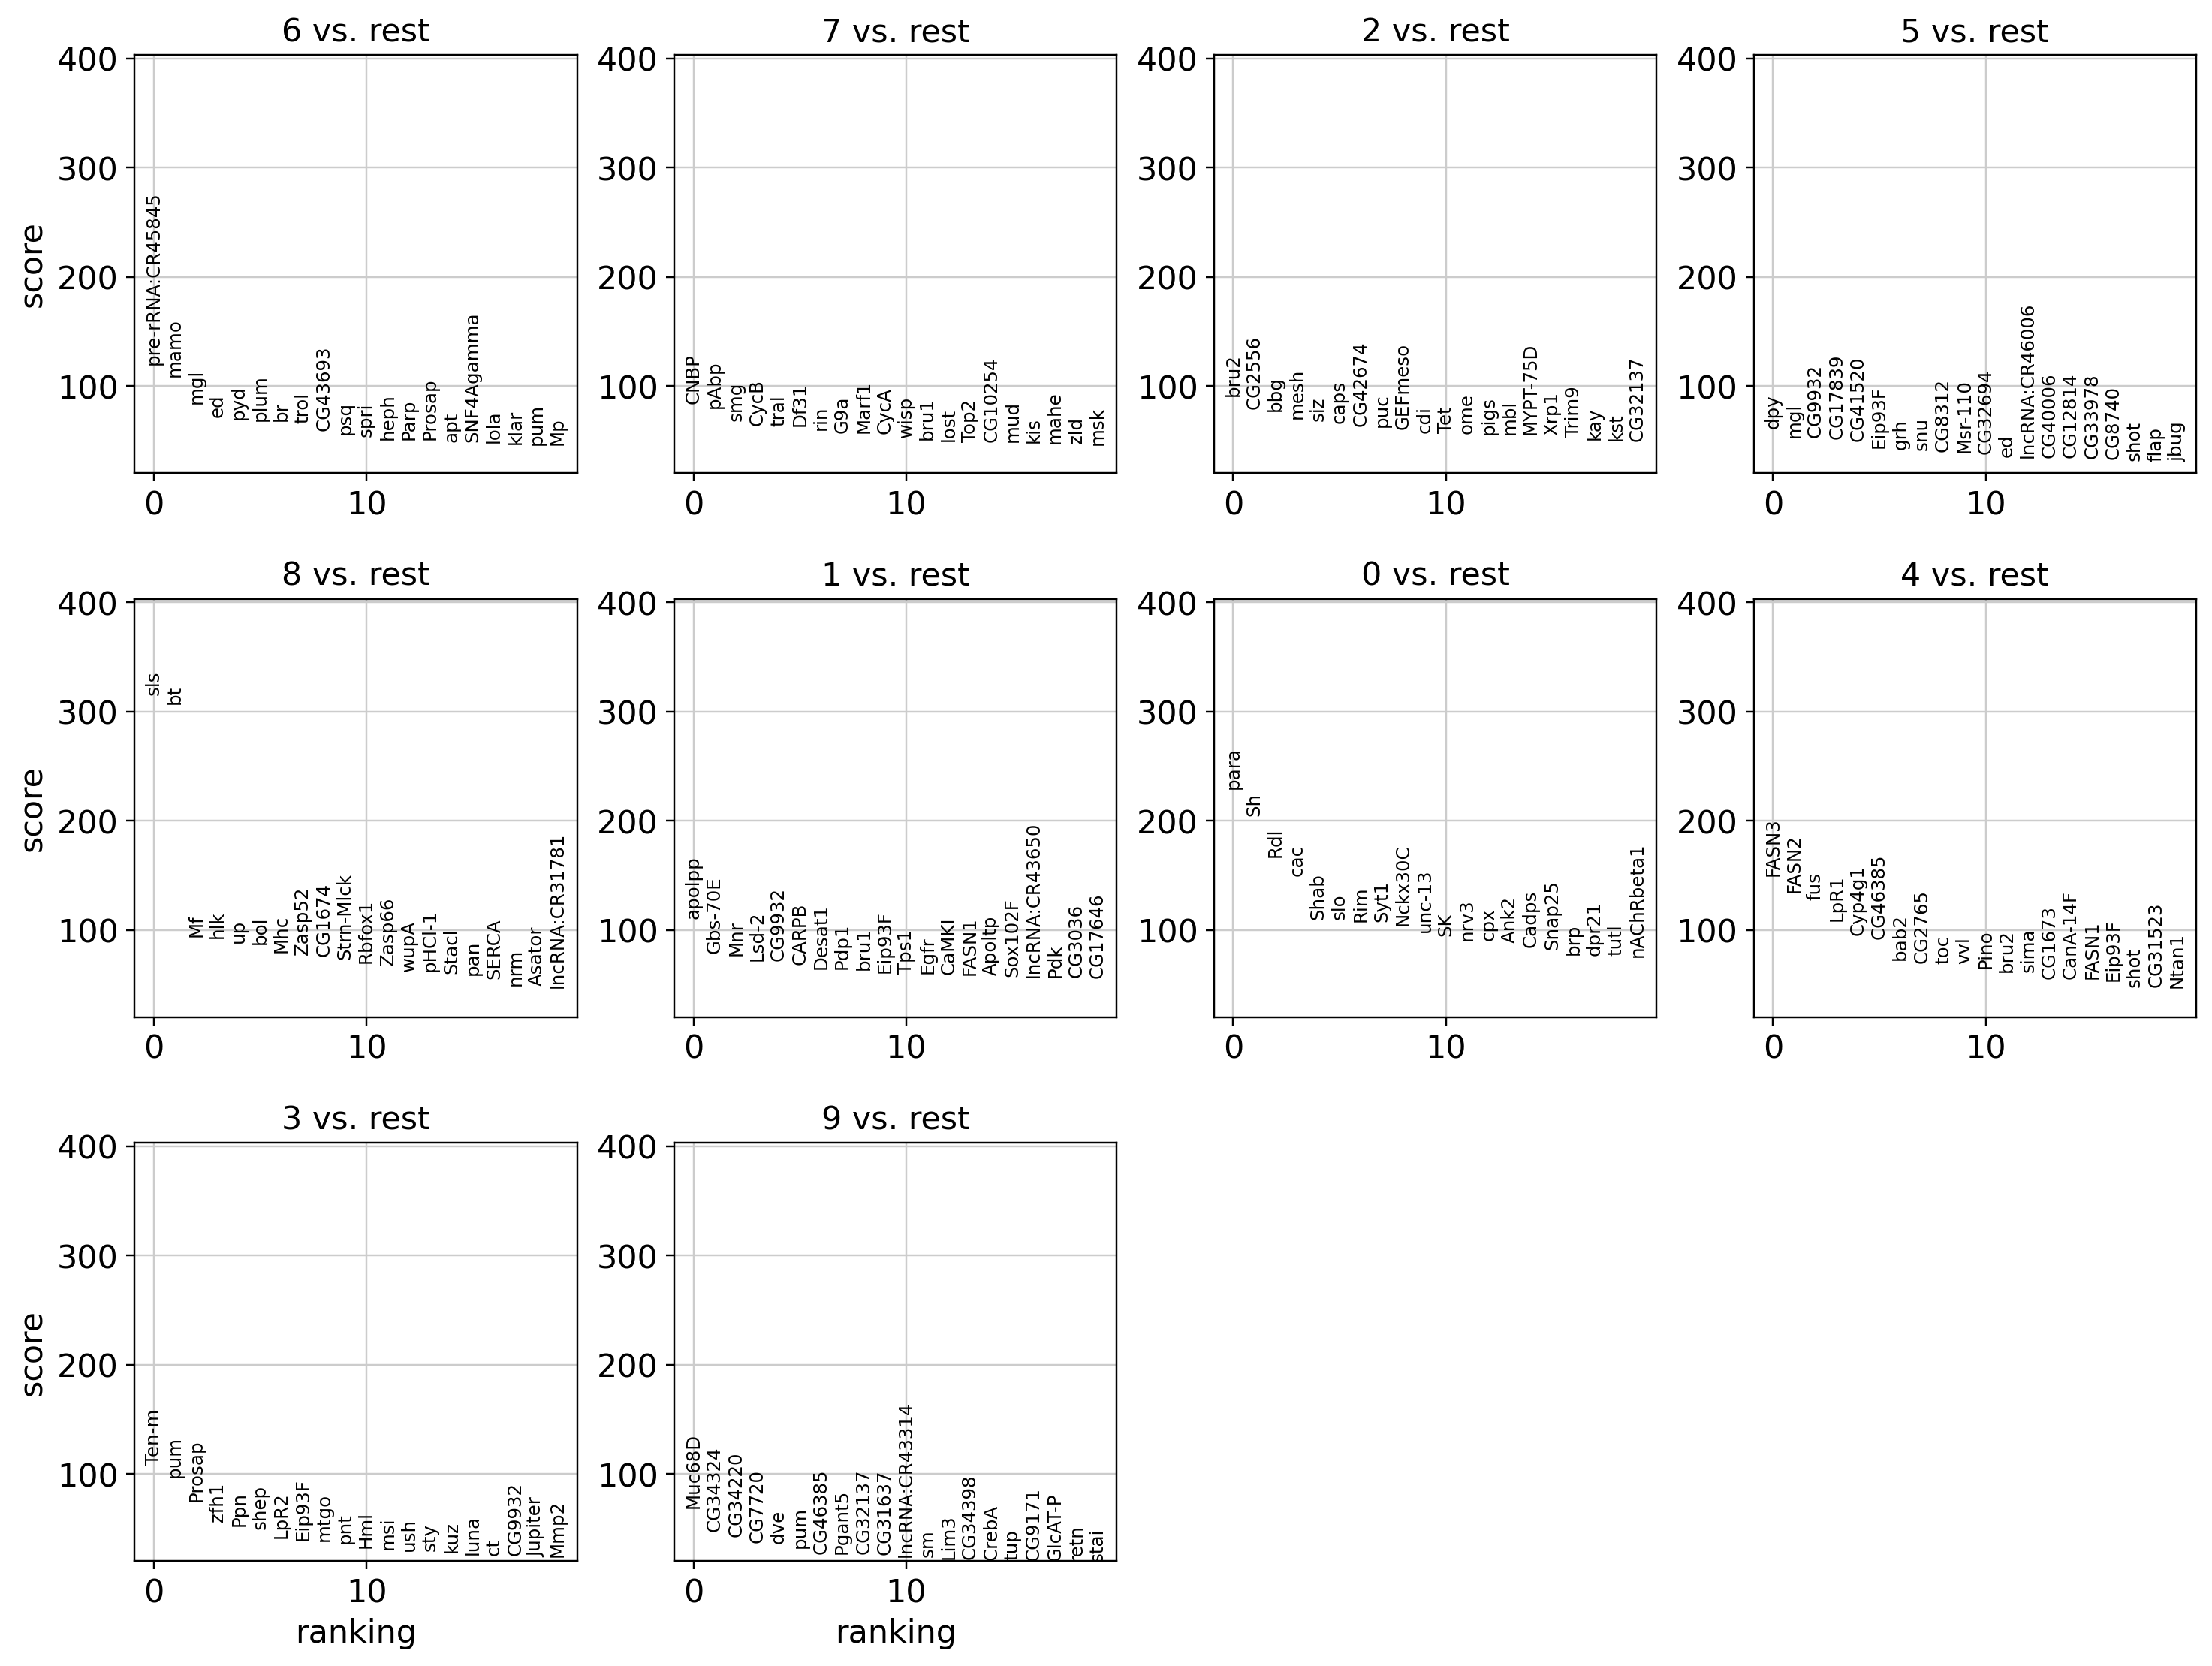

In [65]:
sc.pl.rank_genes_groups(
    adata,
    n_genes=20,
    title="Ranked Genes (t-test)",
    cmap="viridis",
    gene_symbols="gene_symbol", 
)

## Manual cell type annotation with marker genes

In [70]:
marker_genes = {
    "Epithelial Cells": [
        "shg", "Fas3", "dlg1", "Nrx-IV", "crb", "PatJ", "cora", "par-6", "scrib"
    ],
    
    "Neuronal Cells": [
        "elav", "nSyb", "Syt1", "VAChT", "VGlut", "Gad1", "ChAT", 
        "brp", "repo", "Dscam1", "Rbp9", "pros", "fru", "neuroglian"
    ],
    
    "Muscle Cells": [
        "Mhc", "Mef2", "Zasp66", "Actn", "Tropomyosin 1 (Tm1)", 
        "Tropomyosin 2 (Tm2)", "wupA", "sls", "babo", "Tmod"
    ],
    
    "Stromal Cells": [
        "bab2", "en", "hh", "tj", "upd", "Fas3", "eya", "Hand", 
        "Actn", "esg", "vkg", "LanB1", "LanA", "Trol", "col4a1", "collagen IV"
    ],
    
    "Intestinal Stem Cells": [
        "esg", "Dl", "Sox21a", "Delta", "klu", "klu-RB", "mir-8", 
        "zfh2", "erm", "Eip93F", "Notch"
    ],
    
    "Enteroblasts": [
        "klu", "E(spl)m3-HLH", "E(spl)mbeta-HLH", "Sox100B", 
        "neur", "Numb", "Eip75B"
    ],
    
    "Enterocytes": [
        "Pdm1", "Nub", "alpha-Trypsin", "Myo31DF", "caudal", "Odd", "CG30377"
    ],
    
    "Enteroendocrine Cells": [
        "pros", "esg", "AstA", "AstC", "Dh31", "Tk", "NPF", 
        "7B2", "Scg-betaA", "Fer2"
    ]
    }

In [71]:
marker_genes2 = {
    "Epithelial Cells": ["shg", "Fas3"],
    "Neuronal Cells": ["Gad1", "VGlut", "VAChT", "Syt1", "nSyb", "elav"],
    "Muscle Cells": ["Mhc", "Mef2"],
    "Stromal Cells": ["bab2", "en", "hh", "tj", "Fas3", "eya", "Hand", "Actn", "esg"],
    "Intestinal Stem Cells": ["esg", "Dl", "Sox21a"],
    "Enteroblasts": ["klu"]}

In [72]:
adata.obs["cell type"] = adata.obs["leiden_res_0.20"].map(marker_genes).astype("category")

In [73]:
gene_symbols_set = set(adata.var['gene_symbol'])

marker_genes_filtered = {
    cell_type: [g for g in genes if g in gene_symbols_set]
    for cell_type, genes in marker_genes.items()
    if any(g in gene_symbols_set for g in genes)  # keep cell type only if at least one gene is valid
}


categories: 0, 1, 2, etc.
var_group_labels: Epithelial Cells, Neuronal Cells, Muscle Cells, etc.


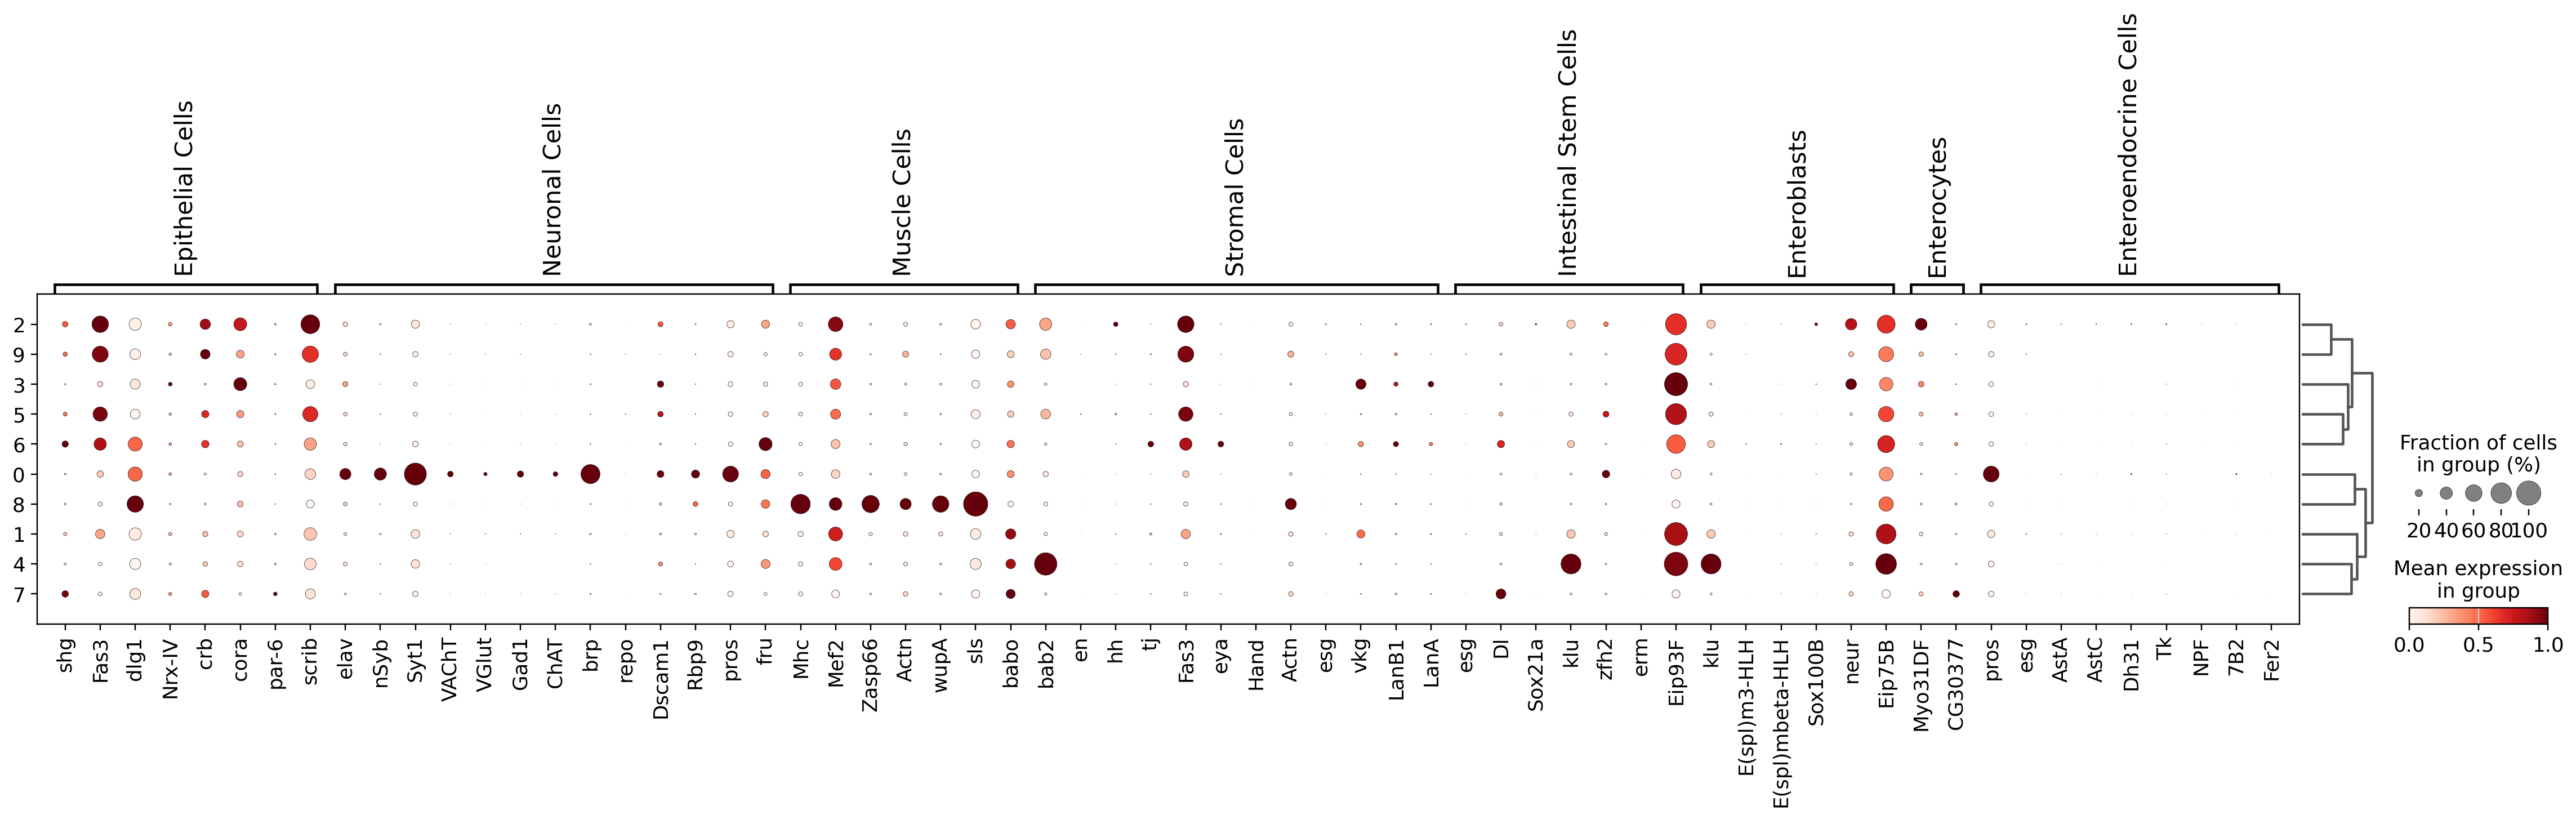

In [74]:
sc.pl.dotplot(
    adata,
    marker_genes_filtered,
    groupby="leiden_res_0.20",
    standard_scale="var",
    gene_symbols="gene_symbol",
    dendrogram=True
)


categories: 0, 1, 2, etc.
var_group_labels: Epithelial Cells, Neuronal Cells, Muscle Cells, etc.


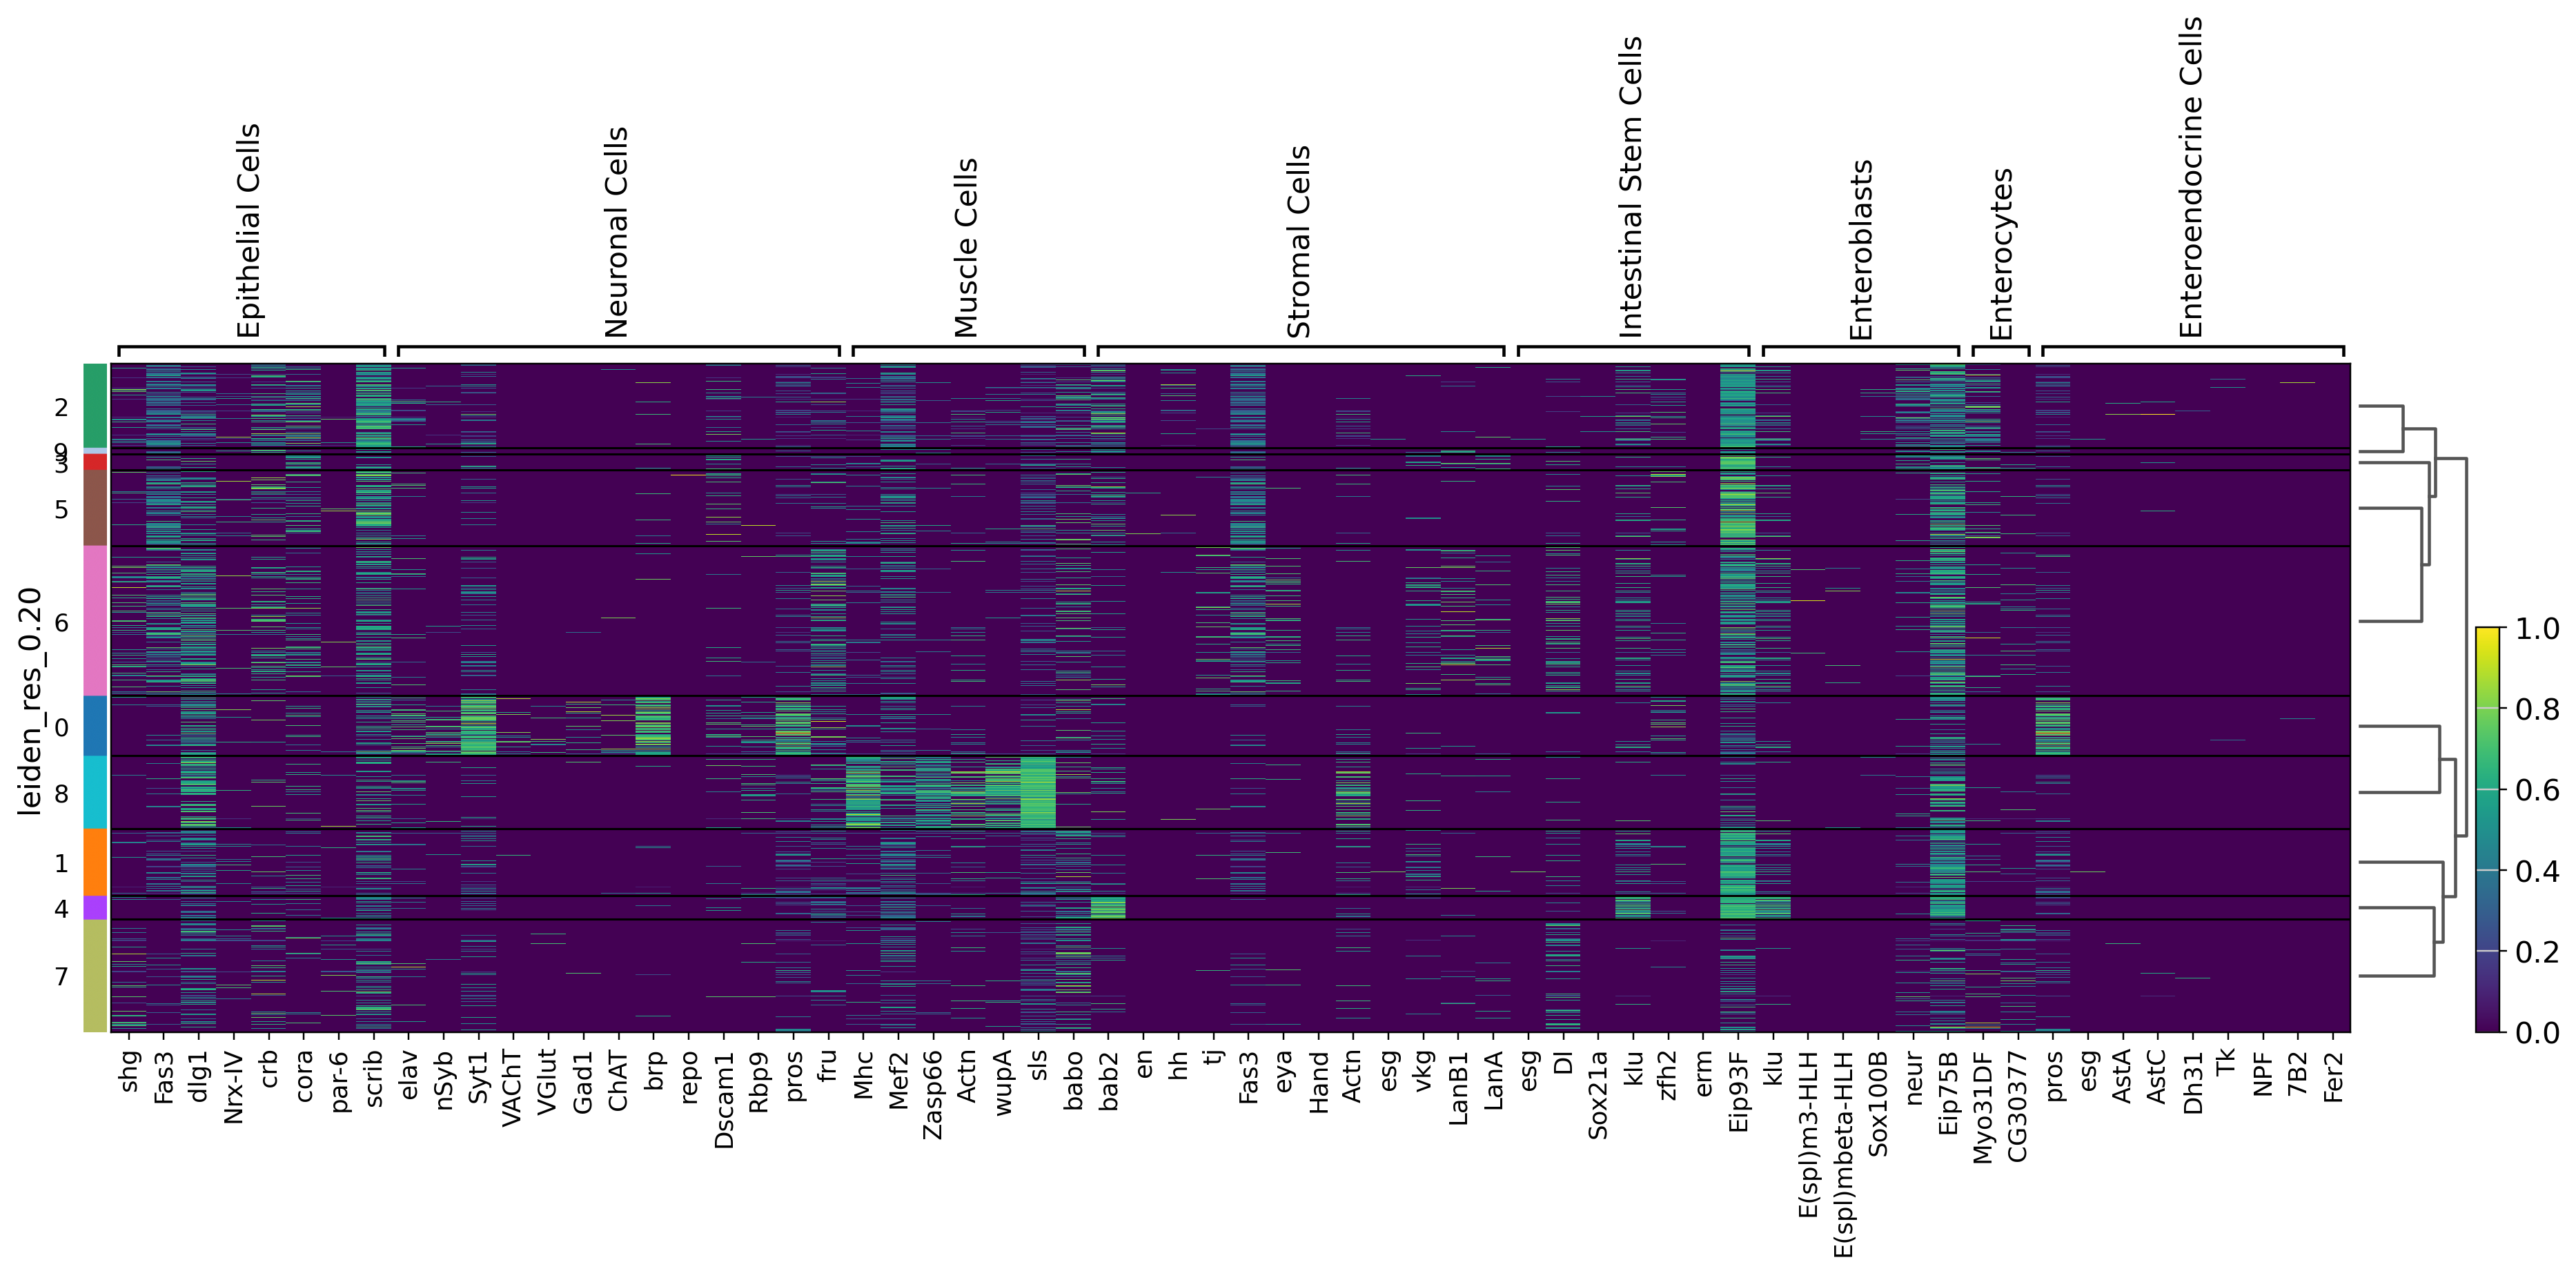

In [75]:
sc.pl.heatmap(
    adata,
    marker_genes_filtered,
    groupby="leiden_res_0.20",
    standard_scale="var",           # same as in dotplot
    gene_symbols="gene_symbol",     # if `marker_genes_filtered` contains gene IDs
    dendrogram=True,
    show_gene_labels=True,  # show gene labels
)